#### Import all necessary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import json
import re
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVR, OneClassSVM
import xgboost as XGBRegressor
import warnings

warnings.filterwarnings("ignore")

#### Load the CSV file and inspect schema


In [2]:
df = pd.read_csv(
    "data/vehicle_data.csv", header=None, names=["timestamp", "filename", "details"]
)
print(f"Initial Shape: {df.shape}")
print("\nDataset Info:")
df.info()
print("\nFirst 5 rows:")
display(df.head())

Initial Shape: (34047, 3)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34047 entries, 0 to 34046
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  34047 non-null  object
 1   filename   34047 non-null  object
 2   details    34047 non-null  object
dtypes: object(3)
memory usage: 798.1+ KB

First 5 rows:


,timestamp,filename,details
0,17/8/2024 23:51,20240818095136_T_bottom_half.mp4,"{'class_name': 'car', 'device_name': 'cam10-lo..."
1,17/8/2024 23:51,20240818095136_T_bottom_half.mp4,"{'class_name': 'car', 'device_name': 'cam10-lo..."
2,18/8/2024 1:16,20240818111633_T_bottom_half.mp4,"{'class_name': 'car', 'device_name': 'cam10-lo..."
3,18/8/2024 1:16,20240818111633_T_bottom_half.mp4,"{'class_name': 'car', 'device_name': 'cam10-lo..."
4,18/8/2024 1:16,20240818111633_T_bottom_half.mp4,"{'class_name': 'utility', 'device_name': 'cam1..."


#### Parse the "details" column to flat columns


In [3]:
print("\nParsing 'details' Column")
print("---------------------------")


def parse_details(detail_str):
    try:
        if pd.isna(detail_str) or detail_str == "":
            return {}
        return ast.literal_eval(str(detail_str))
    except (ValueError, SyntaxError):
        print(f"Failed to parse: {detail_str[:50]}...")
        return {}


parsed_details = df["details"].apply(parse_details)

all_keys = set()
for d in parsed_details:
    all_keys.update(d.keys())

print(f"There are {len(all_keys)} keys in the details dictionary: {sorted(all_keys)}")


for key in all_keys:
    df[key] = parsed_details.apply(lambda d: d.get(key, np.nan))

df = df.drop(columns=["details"])
print("\nColumns after parsing:")
print(df.columns.tolist())
print("\nNew schema and its sample data after parsing:")
df.head()


Parsing 'details' Column
---------------------------
There are 8 keys in the details dictionary: ['class_name', 'device_name', 'estimated_speed', 'frame_number', 'last_appearance', 'tracked_id', 'vehicle_class', 'zone_label']

Columns after parsing:
['timestamp', 'filename', 'vehicle_class', 'device_name', 'class_name', 'tracked_id', 'frame_number', 'last_appearance', 'zone_label', 'estimated_speed']

New schema and its sample data after parsing:


,timestamp,filename,vehicle_class,device_name,class_name,tracked_id,frame_number,last_appearance,zone_label,estimated_speed
0,17/8/2024 23:51,20240818095136_T_bottom_half.mp4,1,cam10-loc-3-north-bound,car,1e9c19c095_1,5,True,Monitor Zone,
1,17/8/2024 23:51,20240818095136_T_bottom_half.mp4,1,cam10-loc-3-north-bound,car,1e9c19c095_5,20,True,Monitor Zone,99.320225
2,18/8/2024 1:16,20240818111633_T_bottom_half.mp4,1,cam10-loc-3-north-bound,car,2fc9c67b25_7,46,True,Monitor Zone,
3,18/8/2024 1:16,20240818111633_T_bottom_half.mp4,1,cam10-loc-3-north-bound,car,2fc9c67b25_5,51,True,Monitor Zone,105.0
4,18/8/2024 1:16,20240818111633_T_bottom_half.mp4,1,cam10-loc-3-north-bound,utility,2fc9c67b25_17,116,True,Monitor Zone,105.0


## Data Cleaning

#

#### .:. Converting Data Types


In [4]:
try:
    df["timestamp"] = pd.to_datetime(df["timestamp"], format="%d/%m/%Y %H:%M")
    print("Converted timestamp to timestamps")
except Exception as e:
    print(f"Failed to convert timestamps with specific format: {e}")


numeric_cols = ["estimated_speed", "vehicle_class", "frame_number"]
for col in numeric_cols:
    if col in df.columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            # Convert empty strings to NaN first
            df[col] = df[col].replace("", np.nan)
            df[col] = pd.to_numeric(df[col], errors="coerce")
            print(f"Converted {col} to numeric")


if "last_appearance" in df.columns:
    if not pd.api.types.is_bool_dtype(df["last_appearance"]):
        df["last_appearance"] = df["last_appearance"].astype("boolean")
        print(f"✓ Converted last_appearance to boolean")

categorical_cols = ["class_name", "device_name", "zone_label", "tracked_id"]
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")
        print(f"Converted {col} to category")

Converted timestamp to timestamps
Converted estimated_speed to numeric
Converted class_name to category
Converted device_name to category
Converted zone_label to category
Converted tracked_id to category


In [5]:
print("\nMissing values before cleaning:")
missing_percentage = df.isnull().sum() / len(df) * 100
for col, pct in missing_percentage.items():
    if pct > 0:
        print(f"{col}: {pct:.2f}% missing")


Missing values before cleaning:
tracked_id: 0.09% missing
estimated_speed: 17.52% missing


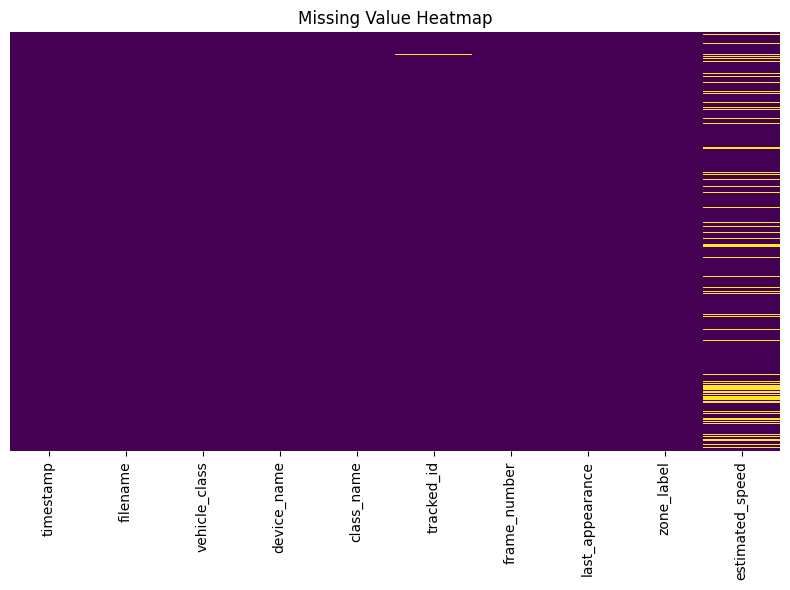

In [6]:
# Visualize missing values

plt.figure(figsize=(8, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Missing Value Heatmap")
plt.tight_layout()
plt.show()

In [7]:
# Handle missing values
print("\nHandling missing values...")
# For numeric columns
for col in numeric_cols:
    if col in df.columns and df[col].isnull().sum() > 0:
        if df[col].notnull().sum() > 0:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"Filled missing values in {col} with median: {median_val}")
        else:
            df[col].fillna(0, inplace=True)
            print(f"All values in {col} were NaN, filled with 0")

# For categorical columns
cat_cols = ["class_name", "device_name", "zone_label", "tracked_id"]
for col in cat_cols:
    if col in df.columns and df[col].isnull().sum() > 0:
        mode_result = df[col].mode()
        if len(mode_result) > 0 and df[col].notnull().sum() > 0:
            mode_val = mode_result[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"Filled missing values in {col} with mode: {mode_val}")
        else:
            df[col].fillna("unknown", inplace=True)
            print(f"No mode found for {col}, filled with 'unknown'")

#Check for duplicates
print("\nChecking for duplicates...")
duplicates = df.duplicated().sum()
print(f"Found {duplicates} duplicate rows")
if duplicates > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"Removed duplicates. New shape: {df.shape}")


Handling missing values...
Filled missing values in estimated_speed with median: 103.9388383795954
Filled missing values in tracked_id with mode: 001568c086_11

Checking for duplicates...
Found 0 duplicate rows


In [8]:
# Export the cleaned dataframe to CSV
output_path = "data/processed_vehicle_data.csv"
df.to_csv(output_path, index=False, na_rep="NA")
print(f" Processed data exported to {output_path}")

 Processed data exported to data/processed_vehicle_data.csv


### Exploratory Data Analysis (EDA)



Summary Statistics:


,timestamp,filename,vehicle_class,device_name,class_name,tracked_id,frame_number,last_appearance,zone_label,estimated_speed
count,34047,34047,34047.000000,34047,34047,34047,34047.000000,34047,34047,34047.000000
unique,NaN,1997,NaN,1,6,34015,NaN,1,1,NaN
top,NaN,20240824152645_T_bottom_half.mp4,NaN,cam10-loc-3-north-bound,car,001568c086_11,NaN,True,Monitor Zone,NaN
freq,NaN,46,NaN,34047,20506,33,NaN,34047,34047,NaN
mean,2024-08-21 20:00:59.245748480,NaN,1.632420,NaN,NaN,NaN,436.678679,NaN,NaN,104.651053
min,2024-08-17 23:51:00,NaN,1.000000,NaN,NaN,NaN,2.000000,NaN,NaN,10.000000
25%,2024-08-20 00:48:00,NaN,1.000000,NaN,NaN,NaN,216.000000,NaN,NaN,99.259205
50%,2024-08-22 03:43:00,NaN,1.000000,NaN,NaN,NaN,434.000000,NaN,NaN,103.938838
75%,2024-08-23 07:21:00,NaN,1.000000,NaN,NaN,NaN,650.000000,NaN,NaN,107.168833
max,2024-08-26 05:48:00,NaN,12.000000,NaN,NaN,NaN,1473.000000,NaN,NaN,150.000000



Distribution Visualizations:


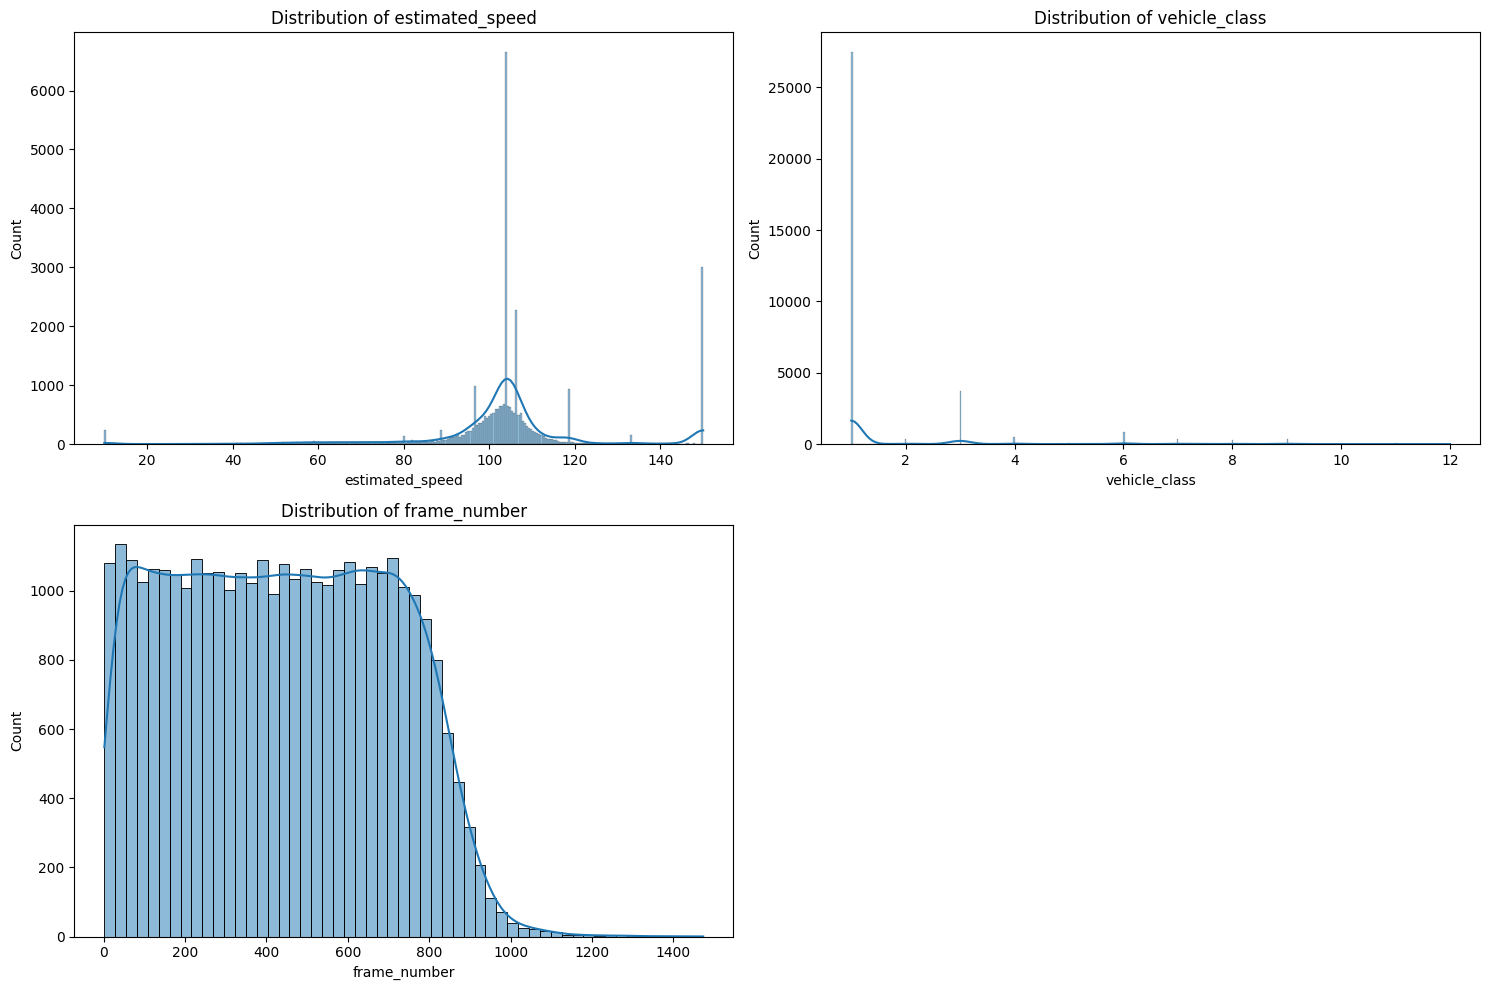


Time-based Analysis:


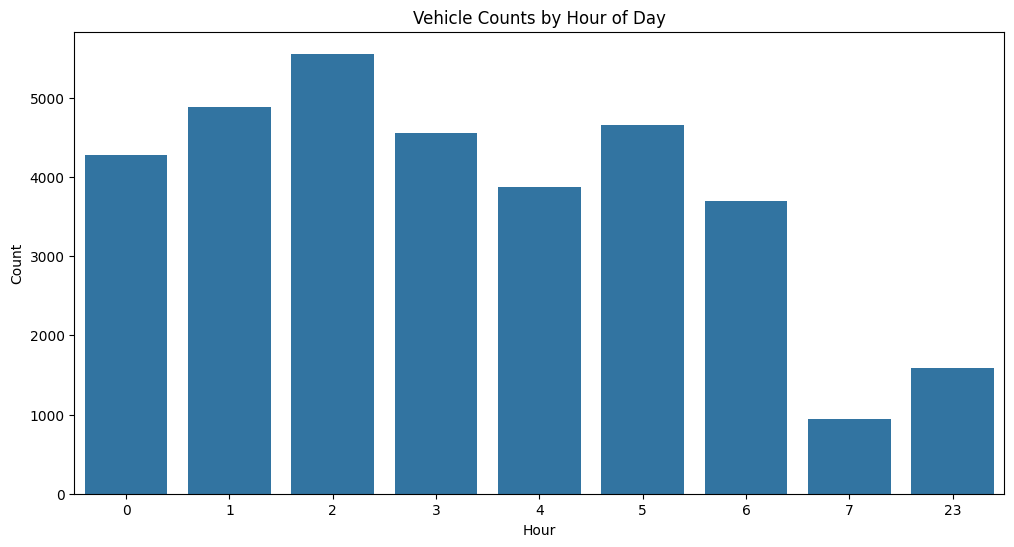

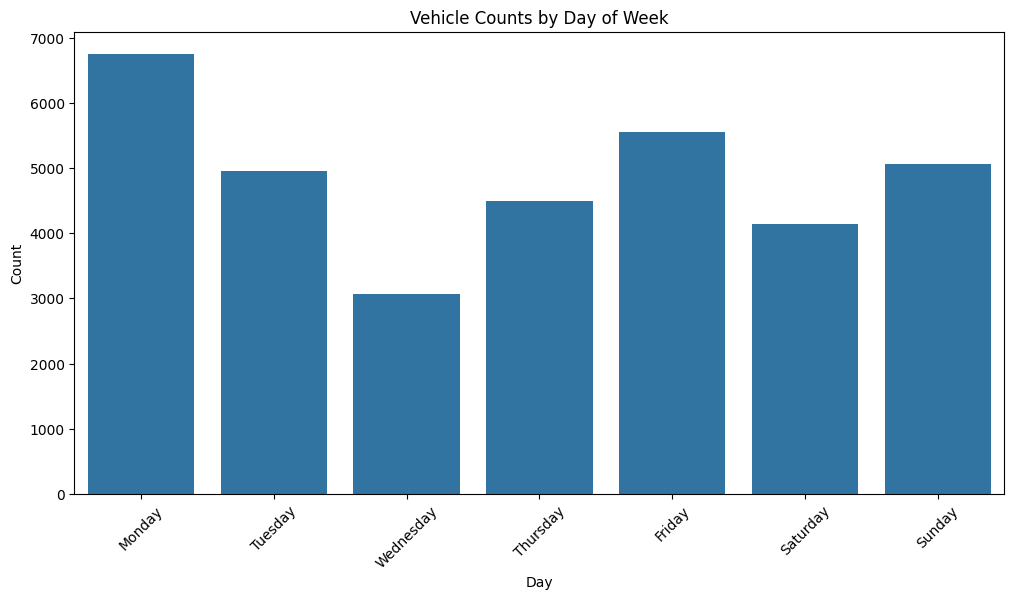

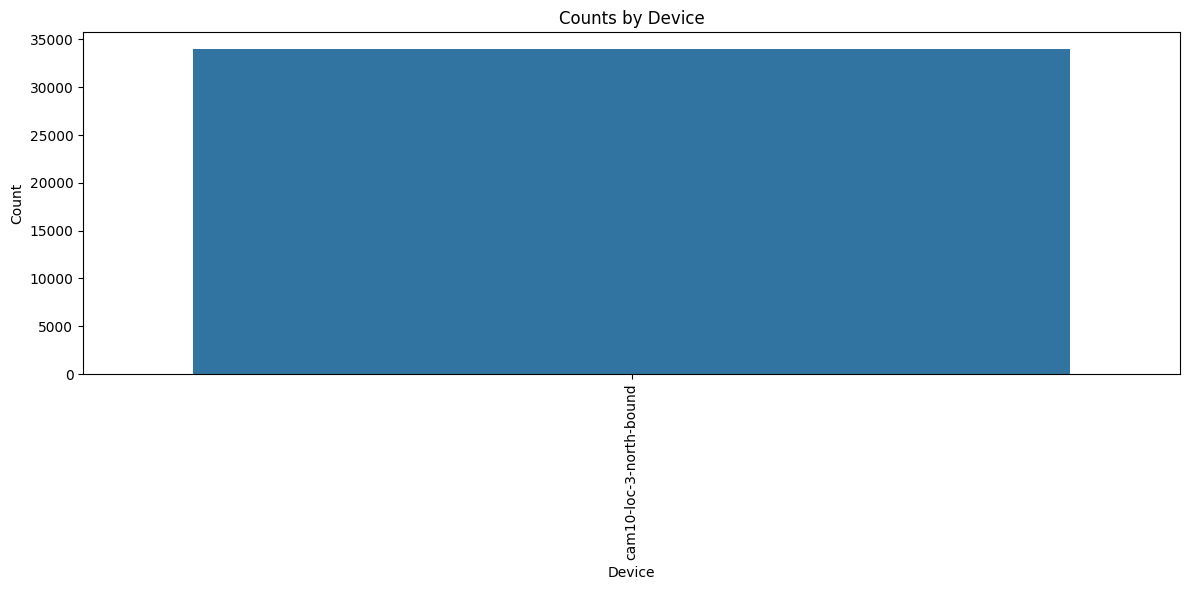

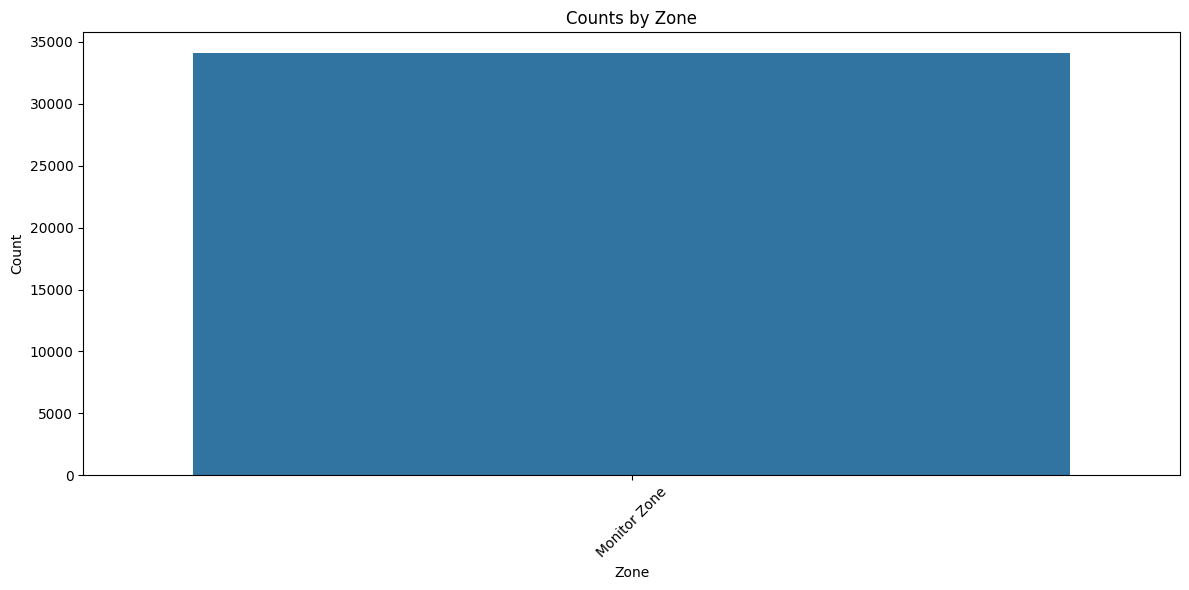


Vehicle Class Analysis:


class_name,bus,car,motorcycle,truck,utility,van
vehicle_class,,,,,,
1,0,20270,127,0,4708,2375
2,0,236,0,0,122,31
3,115,0,0,3608,0,0
4,20,0,0,492,0,0
5,0,0,0,58,0,0
6,9,0,0,811,0,0
7,7,0,0,321,0,0
8,1,0,0,253,0,0
9,0,0,0,362,0,0


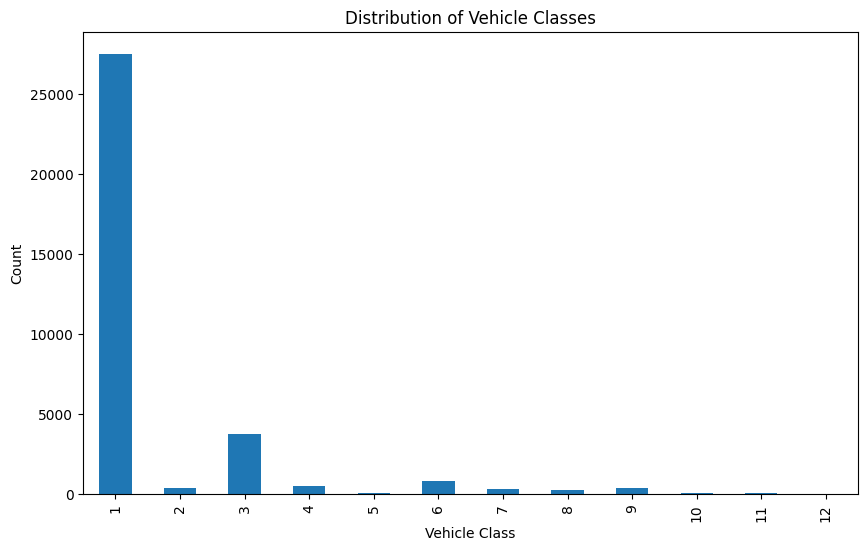


Speed Analysis:
Average speed: 104.65
Maximum speed: 150.00
Minimum speed: 10.00


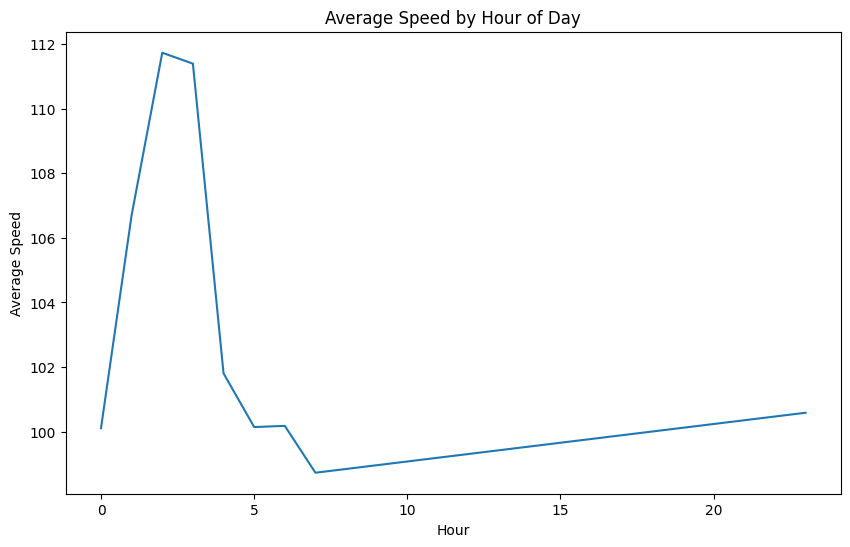

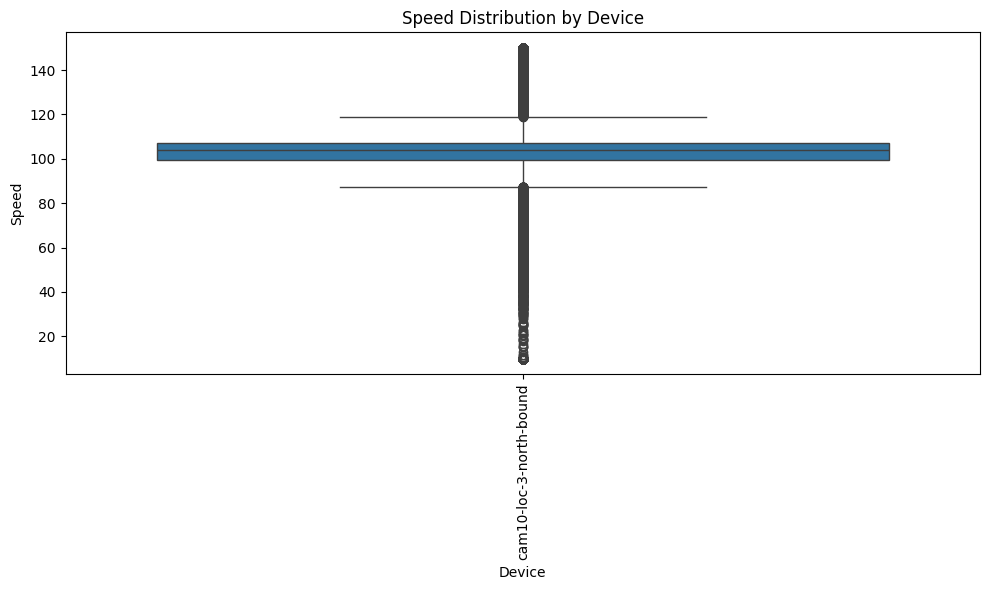

In [9]:
print("\nSummary Statistics:")
display(df.describe(include="all"))

# Distribution visualizations
print("\nDistribution Visualizations:")

# Create a figure for numeric distributions
numeric_cols_present = [
    col for col in numeric_cols if col in df.columns and df[col].notnull().sum() > 0
]
if numeric_cols_present:
    plt.figure(figsize=(15, 5 * ((len(numeric_cols_present) + 1) // 2)))
    for i, col in enumerate(numeric_cols_present):
        plt.subplot(((len(numeric_cols_present) + 1) // 2), 2, i + 1)
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()



# Time-based patterns
print("\nTime-based Analysis:")
if pd.api.types.is_datetime64_dtype(df["timestamp"]):
    # Extract time components
    df["hour"] = df["timestamp"].dt.hour
    df["day"] = df["timestamp"].dt.day
    df["day_of_week"] = df["timestamp"].dt.day_name()

    # Vehicle counts by hour
    plt.figure(figsize=(12, 6))
    hourly_counts = df.groupby("hour").size()
    sns.barplot(x=hourly_counts.index, y=hourly_counts.values)
    plt.title("Vehicle Counts by Hour of Day")
    plt.xlabel("Hour")
    plt.ylabel("Count")
    plt.show()

    # Vehicle counts by day of week
    plt.figure(figsize=(12, 6))
    day_order = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]
    day_counts = df["day_of_week"].value_counts().reindex(day_order)
    sns.barplot(x=day_counts.index, y=day_counts.values)
    plt.title("Vehicle Counts by Day of Week")
    plt.xlabel("Day")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

# Device and zone analysis
if "device_name" in df.columns and df["device_name"].notnull().sum() > 0:
    plt.figure(figsize=(12, 6))
    device_counts = df["device_name"].value_counts()
    sns.barplot(x=device_counts.index, y=device_counts.values)
    plt.title("Counts by Device")
    plt.xlabel("Device")
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

if "zone_label" in df.columns and df["zone_label"].notnull().sum() > 0:
    plt.figure(figsize=(12, 6))
    zone_counts = df["zone_label"].value_counts()
    sns.barplot(x=zone_counts.index, y=zone_counts.values)
    plt.title("Counts by Zone")
    plt.xlabel("Zone")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Vehicle class analysis
if "vehicle_class" in df.columns and "class_name" in df.columns:
    # Create a cross-tabulation of vehicle_class and class_name
    if df["vehicle_class"].notnull().sum() > 0 and df["class_name"].notnull().sum() > 0:
        print("\nVehicle Class Analysis:")
        class_crosstab = pd.crosstab(df["vehicle_class"], df["class_name"])
        display(class_crosstab)

        # Plot vehicle class distribution
        plt.figure(figsize=(10, 6))
        df["vehicle_class"].value_counts().sort_index().plot(kind="bar")
        plt.title("Distribution of Vehicle Classes")
        plt.xlabel("Vehicle Class")
        plt.ylabel("Count")
        plt.show()

# Speed analysis if available
if "estimated_speed" in df.columns and df["estimated_speed"].notnull().sum() > 0:
    print("\nSpeed Analysis:")
    print(f"Average speed: {df['estimated_speed'].mean():.2f}")
    print(f"Maximum speed: {df['estimated_speed'].max():.2f}")
    print(f"Minimum speed: {df['estimated_speed'].min():.2f}")

    # Speed by hour
    plt.figure(figsize=(10, 6))
    sns.lineplot(x="hour", y="estimated_speed", data=df, ci=None)
    plt.title("Average Speed by Hour of Day")
    plt.xlabel("Hour")
    plt.ylabel("Average Speed")
    plt.show()

    # Speed by device
    if "device_name" in df.columns and df["device_name"].notnull().sum() > 0:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x="device_name", y="estimated_speed", data=df)
        plt.title("Speed Distribution by Device")
        plt.xlabel("Device")
        plt.ylabel("Speed")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

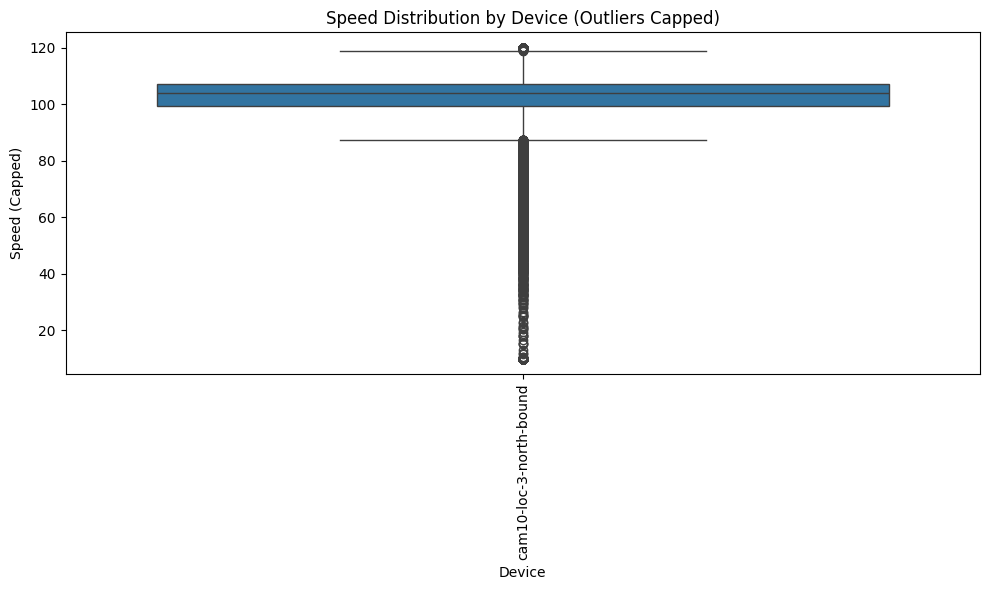

In [10]:
# Define realistic bounds first
realistic_min = 0  # Stationary vehicles
realistic_max = 120  # Reasonable highway speed

# Handling outliers - Cap outliers (Winsorization)
df["estimated_speed_capped"] = df["estimated_speed"].clip(
    lower=realistic_min, upper=realistic_max
)

# Speed by device - USE CAPPED DATA
if "device_name" in df.columns and df["device_name"].notnull().sum() > 0:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="device_name", y="estimated_speed_capped", data=df)  # Changed here
    plt.title("Speed Distribution by Device (Outliers Capped)")
    plt.xlabel("Device")
    plt.ylabel("Speed (Capped)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

### Feature Engineering


In [11]:
# Feature Engineering
print("\n Feature Engineering ")
print("----------------------------------")

#  Basic Temporal Features
if pd.api.types.is_datetime64_dtype(df["timestamp"]):
    # Extract basic time components
    df["hour"] = df["timestamp"].dt.hour
    df["day_of_week"] = df["timestamp"].dt.day_name()
    df["is_weekend"] = df["timestamp"].dt.dayofweek >= 5  # 5=Saturday, 6=Sunday

    # Simple time categories
    df["time_period"] = pd.cut(
        df["hour"],
        bins=[0, 6, 12, 18, 24],
        labels=["Night", "Morning", "Afternoon", "Evening"],
    )

#  Speed Categories
if "estimated_speed" in df.columns:
    # Create simple speed categories using pd.cut
    df["speed_category"] = pd.cut(
        df["estimated_speed"],
        bins=[0, 40, 80, float("inf")],
        labels=["slow", "medium", "fast"],
    )

    print("Created Speed Categories")
    # Show distribution
    print(df["speed_category"].value_counts(dropna=False))
    print("-----------------")

# Simple Encoding
# One-hot encode low-cardinality categoricals
cat_columns = ["class_name", "time_period", "speed_category"]
cat_columns = [col for col in cat_columns if col in df.columns]

if cat_columns:
    # Get dummies for all categorical columns at once
    dummies = pd.get_dummies(df[cat_columns], drop_first=True, dummy_na=False)

    # Join with original dataframe
    df = pd.concat([df, dummies], axis=1)
    print(f" One-hot encoded {len(cat_columns)} categorical features")


# Basic Scaling
# Scale numeric features
num_columns = ["estimated_speed", "hour"]
num_columns = [col for col in num_columns if col in df.columns]

if num_columns:
    # Standardize numeric columns
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[num_columns].fillna(0))

    # Create new column names and add to dataframe
    scaled_columns = [f"{col}_scaled" for col in num_columns]
    df[scaled_columns] = scaled_data

    print(f" Standardized {len(num_columns)} numeric features")

# Show column information
print("\nColumn Information:")
print(f"Total number of columns: {len(df.columns)}")
print("\nColumn names:")
for i, col in enumerate(df.columns):
    print(f"{i+1}. {col}")

# Display sample of engineered data
print("\nTable of Engineered Data:")
display(df.head())


 Feature Engineering 
----------------------------------
Created Speed Categories
speed_category
fast      31619
medium     2083
slow        345
Name: count, dtype: int64
-----------------
 One-hot encoded 3 categorical features
 Standardized 2 numeric features

Column Information:
Total number of columns: 29

Column names:
1. timestamp
2. filename
3. vehicle_class
4. device_name
5. class_name
6. tracked_id
7. frame_number
8. last_appearance
9. zone_label
10. estimated_speed
11. hour
12. day
13. day_of_week
14. estimated_speed_capped
15. is_weekend
16. time_period
17. speed_category
18. class_name_car
19. class_name_motorcycle
20. class_name_truck
21. class_name_utility
22. class_name_van
23. time_period_Morning
24. time_period_Afternoon
25. time_period_Evening
26. speed_category_medium
27. speed_category_fast
28. estimated_speed_scaled
29. hour_scaled

Table of Engineered Data:


,timestamp,filename,vehicle_class,device_name,class_name,tracked_id,frame_number,last_appearance,zone_label,estimated_speed,...,class_name_truck,class_name_utility,class_name_van,time_period_Morning,time_period_Afternoon,time_period_Evening,speed_category_medium,speed_category_fast,estimated_speed_scaled,hour_scaled
0,2024-08-17 23:51:00,20240818095136_T_bottom_half.mp4,1,cam10-loc-3-north-bound,car,1e9c19c095_1,5,True,Monitor Zone,103.938838,...,False,False,False,False,False,True,False,True,-0.034739,4.086195
1,2024-08-17 23:51:00,20240818095136_T_bottom_half.mp4,1,cam10-loc-3-north-bound,car,1e9c19c095_5,20,True,Monitor Zone,99.320225,...,False,False,False,False,False,True,False,True,-0.260016,4.086195
2,2024-08-18 01:16:00,20240818111633_T_bottom_half.mp4,1,cam10-loc-3-north-bound,car,2fc9c67b25_7,46,True,Monitor Zone,103.938838,...,False,False,False,False,False,False,False,True,-0.034739,-0.628375
3,2024-08-18 01:16:00,20240818111633_T_bottom_half.mp4,1,cam10-loc-3-north-bound,car,2fc9c67b25_5,51,True,Monitor Zone,105.000000,...,False,False,False,False,False,False,False,True,0.017020,-0.628375
4,2024-08-18 01:16:00,20240818111633_T_bottom_half.mp4,1,cam10-loc-3-north-bound,utility,2fc9c67b25_17,116,True,Monitor Zone,105.000000,...,False,True,False,False,False,False,False,True,0.017020,-0.628375


### Advanced Analytics & Machine Learning Modeling



Advanced Analytics & Machine Learning Modeling
------------------------------------------------

 Clustering Analysis 
-----------------------
Performing clustering analysis using 9 features
Features used: ['estimated_speed', 'speed_medium', 'speed_fast', 'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday']

 K-Means Clustering


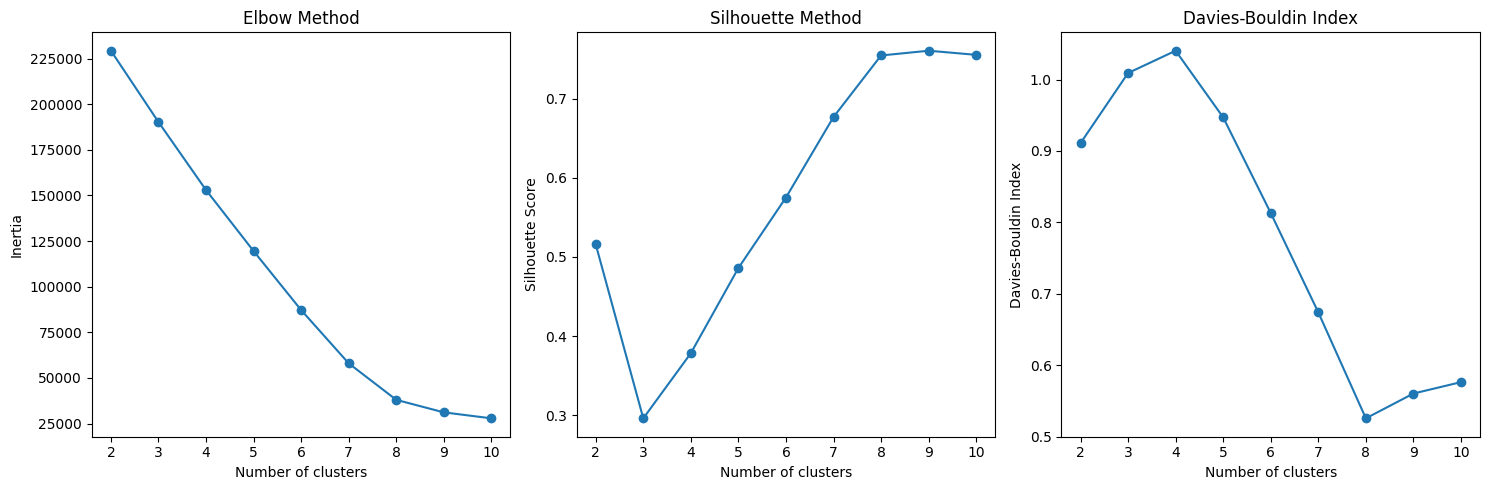

Optimal number of clusters based on silhouette score: 9

 DBSCAN Clustering


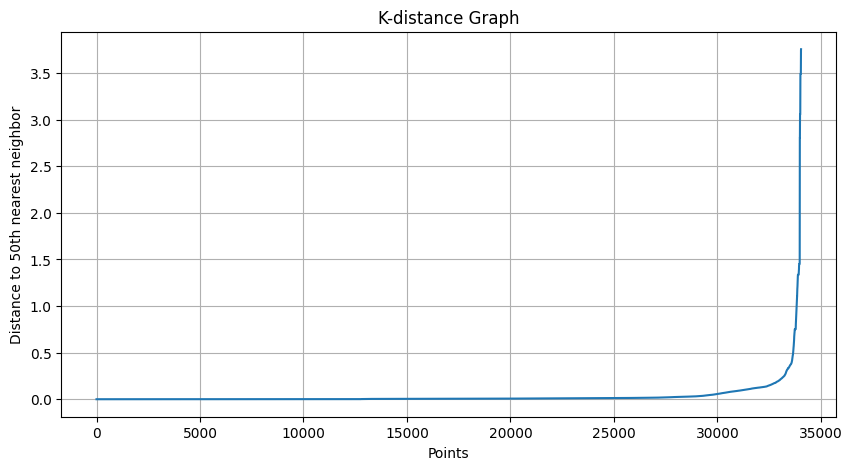

DBSCAN results for different epsilon values:


,eps,n_clusters,n_noise,silhouette,noise_percentage
0,0.50,22,3,0.787415,0.008811
1,0.75,22,3,0.787415,0.008811
2,1.00,21,2,0.787294,0.005874
3,1.25,21,0,0.787268,0.000000
4,1.50,21,0,0.787268,0.000000


Selected epsilon: 0.5

HDBSCAN Clustering
HDBSCAN found 594 clusters with 2170 noise points (6.4% noise)
Silhouette score (excluding noise): 0.732
Homogeneity: 0.192
Completeness: 0.039
V-measure: 0.065

Cluster Visualization


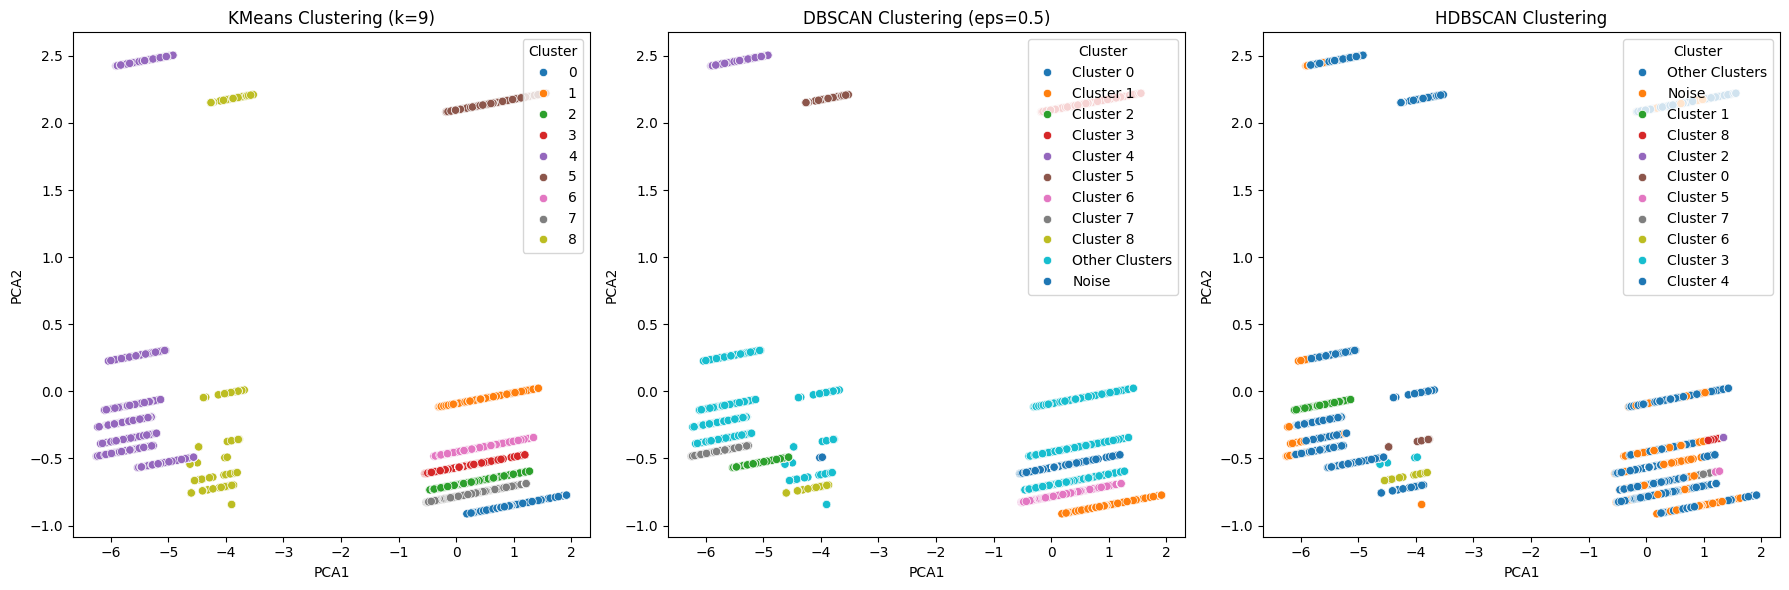

In [12]:
print("\nAdvanced Analytics & Machine Learning Modeling")
print("------------------------------------------------")

print("\n Clustering Analysis ")
print("-----------------------")

cluster_features = ['estimated_speed', 'hour_of_day', 'day_of_month']
if 'speed_category' in df.columns:
    # Get dummies for categorical features if they exist
    if 'speed_category' in df.columns:
        speed_dummies = pd.get_dummies(df['speed_category'], prefix='speed', drop_first=True)
        cluster_features.extend(speed_dummies.columns)
        df = pd.concat([df, speed_dummies], axis=1)
    
    if 'time_of_day' in df.columns:
        time_dummies = pd.get_dummies(df['time_of_day'], prefix='time', drop_first=True)
        cluster_features.extend(time_dummies.columns)
        df = pd.concat([df, time_dummies], axis=1)
    
    if 'day_of_week' in df.columns:
        day_dummies = pd.get_dummies(df['day_of_week'], prefix='day', drop_first=True)
        cluster_features.extend(day_dummies.columns)
        df = pd.concat([df, day_dummies], axis=1)

# Filter to only include features that exist in the dataframe
cluster_features = [col for col in cluster_features if col in df.columns]

if len(cluster_features) >= 2:
    # Prepare the clustering dataset
    cluster_data = df[cluster_features].copy()
    # Drop rows with missing values
    cluster_data = cluster_data.dropna()
    
    if len(cluster_data) > 100:  # Only proceed if we have enough data
        print(f"Performing clustering analysis using {len(cluster_features)} features")
        print(f"Features used: {cluster_features}")
        
        # Standardize the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(cluster_data)
        
        # K-Means Clustering
        print("\n K-Means Clustering")
        
        # Determine optimal number of clusters using elbow method
        inertia = []
        silhouette_scores = []
        davies_bouldin_scores = []
        k_range = range(2, min(11, len(cluster_data) // 10))  # Up to 10 clusters or 1/10th of data
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(scaled_data)
            inertia.append(kmeans.inertia_)
            
            # Calculate silhouette score
            labels = kmeans.labels_
            silhouette_scores.append(silhouette_score(scaled_data, labels))
            
            # Calculate Davies-Bouldin score
            davies_bouldin_scores.append(davies_bouldin_score(scaled_data, labels))
        
        # Plot elbow method results
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.plot(list(k_range), inertia, marker='o')
        plt.xlabel('Number of clusters')
        plt.ylabel('Inertia')
        plt.title('Elbow Method')
        
        plt.subplot(1, 3, 2)
        plt.plot(list(k_range), silhouette_scores, marker='o')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Method')
        
        plt.subplot(1, 3, 3)
        plt.plot(list(k_range), davies_bouldin_scores, marker='o')
        plt.xlabel('Number of clusters')
        plt.ylabel('Davies-Bouldin Index')
        plt.title('Davies-Bouldin Index')
        
        plt.tight_layout()
        plt.show()
        



        # Select optimal k based on silhouette score
        optimal_k = k_range[np.argmax(silhouette_scores)]
        print(f"Optimal number of clusters based on silhouette score: {optimal_k}")
        
        # Apply K-Means with optimal k
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        kmeans_labels = kmeans.fit_predict(scaled_data)
        
        # Add cluster labels to original data
        cluster_data['kmeans_cluster'] = kmeans_labels
        
        # DBSCAN Clustering
        print("\n DBSCAN Clustering")
        
        # Determine eps using nearest neighbors
        from sklearn.neighbors import NearestNeighbors
        
        nn = NearestNeighbors(n_neighbors=min(50, len(scaled_data)-1))
        nn.fit(scaled_data)
        distances, indices = nn.kneighbors(scaled_data)
        
        # Sort and plot distances to find the elbow
        distances = np.sort(distances[:, -1])
        
        plt.figure(figsize=(10, 5))
        plt.plot(distances)
        plt.xlabel('Points')
        plt.ylabel('Distance to 50th nearest neighbor')
        plt.title('K-distance Graph')
        plt.grid(True)
        plt.show()
        
        # Choose eps based on the elbow in the k-distance graph
        eps_candidates = [0.5, 0.75, 1.0, 1.25, 1.5]
        dbscan_results = []
        
        for eps in eps_candidates:
            dbscan = DBSCAN(eps=eps, min_samples=5)
            dbscan_labels = dbscan.fit_predict(scaled_data)
            
            # Calculate metrics if more than one cluster is found
            n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
            n_noise = list(dbscan_labels).count(-1)
            
            if n_clusters > 1:
                # Calculate silhouette score for non-noise points
                non_noise_mask = dbscan_labels != -1
                if sum(non_noise_mask) > 1:
                    sil_score = silhouette_score(
                        scaled_data[non_noise_mask], 
                        dbscan_labels[non_noise_mask]
                    )
                else:
                    sil_score = 0
            else:
                sil_score = 0
                
            dbscan_results.append({
                'eps': eps,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'silhouette': sil_score,
                'noise_percentage': n_noise / len(dbscan_labels) * 100
            })
        
        # Display DBSCAN results
        dbscan_df = pd.DataFrame(dbscan_results)
        print("DBSCAN results for different epsilon values:")
        display(dbscan_df)
        
        # Choose best eps based on silhouette score and reasonable noise percentage
        valid_results = dbscan_df[(dbscan_df['n_clusters'] > 1) & 
                                 (dbscan_df['noise_percentage'] < 50)]
        
        if len(valid_results) > 0:
            best_eps = valid_results.loc[valid_results['silhouette'].idxmax(), 'eps']
        else:
            best_eps = 1.0  # Default if no good results
            
        print(f"Selected epsilon: {best_eps}")
        
        # Apply DBSCAN with best eps
        dbscan = DBSCAN(eps=best_eps, min_samples=5)
        dbscan_labels = dbscan.fit_predict(scaled_data)
        
        # Add DBSCAN labels to data
        cluster_data['dbscan_cluster'] = dbscan_labels
        
        # HDBSCAN Clustering
        print("\nHDBSCAN Clustering")
        
        try:
            from sklearn.cluster import HDBSCAN
            
            # Apply HDBSCAN
            hdbscan = HDBSCAN(min_cluster_size=15, min_samples=5)
            hdbscan_labels = hdbscan.fit_predict(scaled_data)
            
            # Add HDBSCAN labels to data
            cluster_data['hdbscan_cluster'] = hdbscan_labels
            
            # Calculate metrics
            n_clusters_hdbscan = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
            n_noise_hdbscan = list(hdbscan_labels).count(-1)
            
            print(f"HDBSCAN found {n_clusters_hdbscan} clusters with {n_noise_hdbscan} noise points " +
                  f"({n_noise_hdbscan/len(hdbscan_labels)*100:.1f}% noise)")
            
            # Calculate metrics if more than one cluster is found
            if n_clusters_hdbscan > 1:
                # Calculate silhouette score for non-noise points
                non_noise_mask = hdbscan_labels != -1
                if sum(non_noise_mask) > 1:
                    sil_score_hdbscan = silhouette_score(
                        scaled_data[non_noise_mask], 
                        hdbscan_labels[non_noise_mask]
                    )
                    print(f"Silhouette score (excluding noise): {sil_score_hdbscan:.3f}")
                    
                    # Calculate homogeneity, completeness, and V-measure if we have true labels
                    if 'class_name' in df.columns:
                        true_labels = df.loc[cluster_data.index, 'class_name'].astype('category').cat.codes
                        true_labels = true_labels.values[non_noise_mask]
                        cluster_labels = hdbscan_labels[non_noise_mask]
                        
                        h_score = homogeneity_score(true_labels, cluster_labels)
                        c_score = completeness_score(true_labels, cluster_labels)
                        v_score = v_measure_score(true_labels, cluster_labels)
                        
                        print(f"Homogeneity: {h_score:.3f}")
                        print(f"Completeness: {c_score:.3f}")
                        print(f"V-measure: {v_score:.3f}")
            
        except (ImportError, ModuleNotFoundError):
            print("HDBSCAN not available. Install with: pip install hdbscan")
        
        # Dimensionality Reduction for Visualization
        print("\nCluster Visualization")
        
        # Apply PCA for visualization
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_data)
        
        # Create visualization dataframe
        viz_df = pd.DataFrame({
            'PCA1': pca_result[:, 0],
            'PCA2': pca_result[:, 1],
            'KMeans': kmeans_labels,
            'DBSCAN': dbscan_labels
        })
        
        if 'hdbscan_cluster' in cluster_data.columns:
            viz_df['HDBSCAN'] = hdbscan_labels
        
        # Improve cluster visualization
        plt.figure(figsize=(18, 6))

        # KMeans - limit to fewer clusters if needed
        plt.subplot(1, 3, 1)
        sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans', data=viz_df, palette='tab10', 
                        legend='brief', hue_order=sorted(viz_df['KMeans'].unique()[:10]))
        plt.title(f'KMeans Clustering (k={optimal_k})')
        plt.legend(title='Cluster', loc='upper right', ncol=1)

        # DBSCAN - handle many clusters by coloring noise differently
        plt.subplot(1, 3, 2)
        # Create a copy with simplified coloring
        dbscan_viz = viz_df.copy()
        # Mark noise points (-1) separately, group high-number clusters
        dbscan_viz['DBSCAN_display'] = dbscan_viz['DBSCAN'].apply(
            lambda x: 'Noise' if x == -1 else (f'Cluster {x}' if x < 9 else 'Other Clusters')
        )
        sns.scatterplot(x='PCA1', y='PCA2', hue='DBSCAN_display', data=dbscan_viz, 
                        palette='tab10', legend='brief')
        plt.title(f'DBSCAN Clustering (eps={best_eps})')
        plt.legend(title='Cluster', loc='upper right')

        # HDBSCAN - similar approach
        if 'HDBSCAN' in viz_df.columns:
            plt.subplot(1, 3, 3)
            hdbscan_viz = viz_df.copy()
            hdbscan_viz['HDBSCAN_display'] = hdbscan_viz['HDBSCAN'].apply(
                lambda x: 'Noise' if x == -1 else (f'Cluster {x}' if x < 9 else 'Other Clusters')
            )
            sns.scatterplot(x='PCA1', y='PCA2', hue='HDBSCAN_display', data=hdbscan_viz, 
                            palette='tab10', legend='brief')
            plt.title('HDBSCAN Clustering')
            plt.legend(title='Cluster', loc='upper right')

        plt.tight_layout()
        plt.show()


### Regression Modelling


Regression Modeling
--------------------
Performing regression analysis to predict estimated_speed
Using 7 features
Training set size: 27237
Test set size: 6810

Training Linear Regression...
  RMSE: 15.14
  MAE: 9.98
  R²: 0.47

Training Random Forest...
  RMSE: 15.12
  MAE: 9.96
  R²: 0.47

Training SVR...
  RMSE: 15.93
  MAE: 9.00
  R²: 0.41

Training XGBoost...
  RMSE: 15.12
  MAE: 9.97
  R²: 0.47

Model Comparison:


,RMSE,MAE,R²
Linear Regression,15.139,9.984,0.467
Random Forest,15.124,9.960,0.468
SVR,15.929,9.002,0.410
XGBoost,15.124,9.968,0.468



Actual vs Predicted Results - Random Forest
Sample of 15 predictions:


,Actual,Predicted,Difference,Abs_Error,Percent_Error
0,103.94,111.06,-7.12,7.12,6.85
1,113.45,107.32,6.13,6.13,5.41
2,150.00,109.89,40.11,40.11,26.74
3,150.00,107.32,42.68,42.68,28.46
4,150.00,107.32,42.68,42.68,28.46
5,105.03,104.41,0.62,0.62,0.59
6,100.69,107.32,-6.63,6.63,6.59
7,102.27,109.89,-7.62,7.62,7.45
8,107.27,107.32,-0.04,0.04,0.04
9,105.24,106.02,-0.78,0.78,0.74



Prediction Summary:
Mean Absolute Error: 9.96
Mean Percentage Error: 9.51%
Predictions within 10% of actual: 70.6%


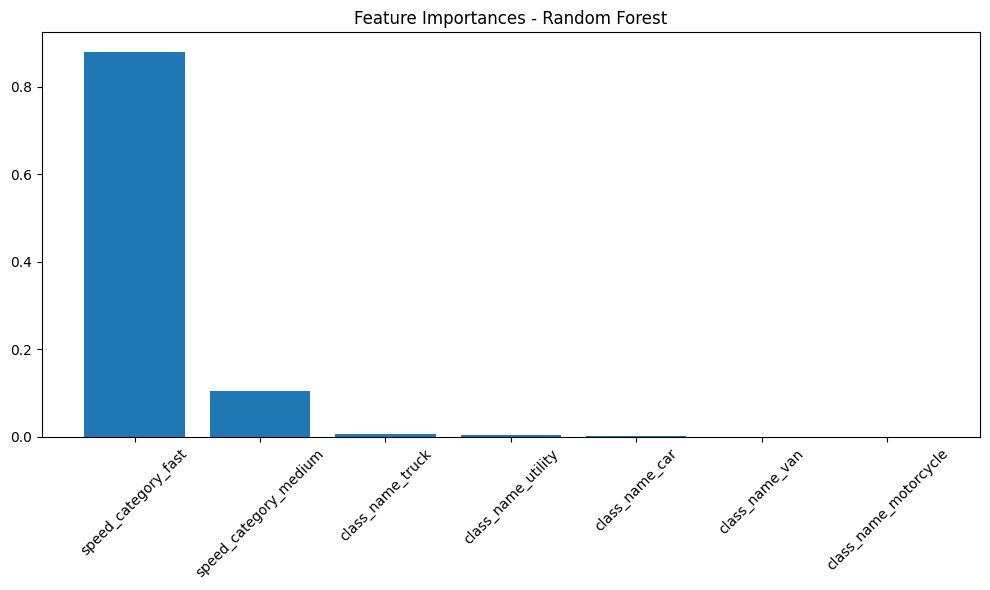


Top 5 Important Features:
speed_category_fast: 0.8808
speed_category_medium: 0.1052
class_name_truck: 0.0071
class_name_utility: 0.0045
class_name_car: 0.0013


In [14]:
# Regression Modeling
print("\nRegression Modeling")
print("--------------------")

if "estimated_speed" in df.columns and df["estimated_speed"].notnull().sum() > 100:
    # Prepare features for regression
    target = "estimated_speed"

    # Select potential features for regression
    numeric_features = [
        "hour_of_day",
        "day_of_month",
        "tracking_count",
        "total_tracking_duration",
    ]
    numeric_features = [col for col in numeric_features if col in df.columns]

    # Add encoded categorical features
    encoded_features = [
        col
        for col in df.columns
        if "_encoded" in col
        or (
            col.startswith(
                ("class_name_", "day_of_week_", "time_of_day_", "speed_category_")
            )
        )
    ]

    # Combine all features
    regression_features = numeric_features + encoded_features
    regression_features = [col for col in regression_features if col in df.columns]

    if len(regression_features) >= 2:
        print(f"Performing regression analysis to predict {target}")
        print(f"Using {len(regression_features)} features")

        # Prepare the regression dataset
        regression_data = df[regression_features + [target]].copy()
        regression_data = regression_data.dropna()

        if len(regression_data) > 100:
            # Split features and target
            X = regression_data[regression_features]
            y = regression_data[target]

            # Train-test split
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
            )

            print(f"Training set size: {X_train.shape[0]}")
            print(f"Test set size: {X_test.shape[0]}")

            # Initialize models
            from xgboost import XGBRegressor
            from sklearn.linear_model import LinearRegression

            models = {
                "Linear Regression": LinearRegression(),
                "Random Forest": RandomForestRegressor(
                    n_estimators=100, random_state=42
                ),
                "SVR": SVR(),
                "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
            }

            # Train and evaluate models
            results = {}

            for name, model in models.items():
                print(f"\nTraining {name}...")

                # Train the model
                model.fit(X_train, y_train)

                # Make predictions
                y_pred = model.predict(X_test)

                # Calculate metrics
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)

                # Store results
                results[name] = {
                    "RMSE": rmse,
                    "MAE": mae,
                    "R²": r2,
                    "model": model,
                    "predictions": y_pred,
                }

                print(f"  RMSE: {rmse:.2f}")
                print(f"  MAE: {mae:.2f}")
                print(f"  R²: {r2:.2f}")

            # Compare model performance
            results_df = pd.DataFrame(
                {
                    name: {
                        "RMSE": results[name]["RMSE"],
                        "MAE": results[name]["MAE"],
                        "R²": results[name]["R²"],
                    }
                    for name in models.keys()
                }
            ).T

            print("\nModel Comparison:")
            display(results_df.round(3))

            # Get best model
            best_model_name = results_df["R²"].idxmax()
            best_predictions = results[best_model_name]["predictions"]

            # Create actual vs predicted comparison table
            comparison_df = pd.DataFrame(
                {
                    "Actual": y_test.values,
                    "Predicted": best_predictions,
                    "Difference": y_test.values - best_predictions,
                    "Abs_Error": np.abs(y_test.values - best_predictions),
                }
            )

            # Add percentage error
            comparison_df["Percent_Error"] = (
                comparison_df["Abs_Error"] / comparison_df["Actual"] * 100
            ).round(2)

            print(f"\nActual vs Predicted Results - {best_model_name}")
            print("Sample of 15 predictions:")
            display(comparison_df.head(15).round(2))

            print(f"\nPrediction Summary:")
            print(f"Mean Absolute Error: {comparison_df['Abs_Error'].mean():.2f}")
            print(
                f"Mean Percentage Error: {comparison_df['Percent_Error'].mean():.2f}%"
            )
            print(
                f"Predictions within 10% of actual: {(comparison_df['Percent_Error'] <= 10).mean()*100:.1f}%"
            )

        

            # Feature importance for tree-based models
            if best_model_name in ["Random Forest", "XGBoost"]:
                model = results[best_model_name]["model"]

                if hasattr(model, "feature_importances_"):
                    importances = model.feature_importances_
                    indices = np.argsort(importances)[::-1]

                    plt.figure(figsize=(10, 6))
                    plt.title(f"Feature Importances - {best_model_name}")
                    plt.bar(
                        range(min(10, X.shape[1])),
                        importances[indices][:10],
                        align="center",
                    )
                    plt.xticks(
                        range(min(10, X.shape[1])),
                        [X.columns[i] for i in indices[:10]],
                        rotation=45,
                    )
                    plt.tight_layout()
                    plt.show()

                    print("\nTop 5 Important Features:")
                    for i in range(min(5, X.shape[1])):
                        print(f"{X.columns[indices[i]]}: {importances[indices[i]]:.4f}")
        else:
            print(
                "Not enough data for regression analysis after removing missing values"
            )
    else:
        print("Not enough features available for regression analysis")
else:
    print(
        "Target variable 'estimated_speed' not available or insufficient data for regression"
    )

### Anomaly Detection


Anomaly Detection
------------------
Performing anomaly detection on vehicle data
Using features for anomaly detection: ['estimated_speed', 'hour', 'day_of_week_num', 'is_weekend_num']

Statistical Methods (Z-score)
Z-score method identified 322 anomalies (1.15% of data)

Isolation Forest
Isolation Forest identified 1404 anomalies (5.00% of data)

Local Outlier Factor
Local Outlier Factor identified 1404 anomalies (5.00% of data)

Anomaly Visualization
Consensus approach identified 383 anomalies (1.36% of data)


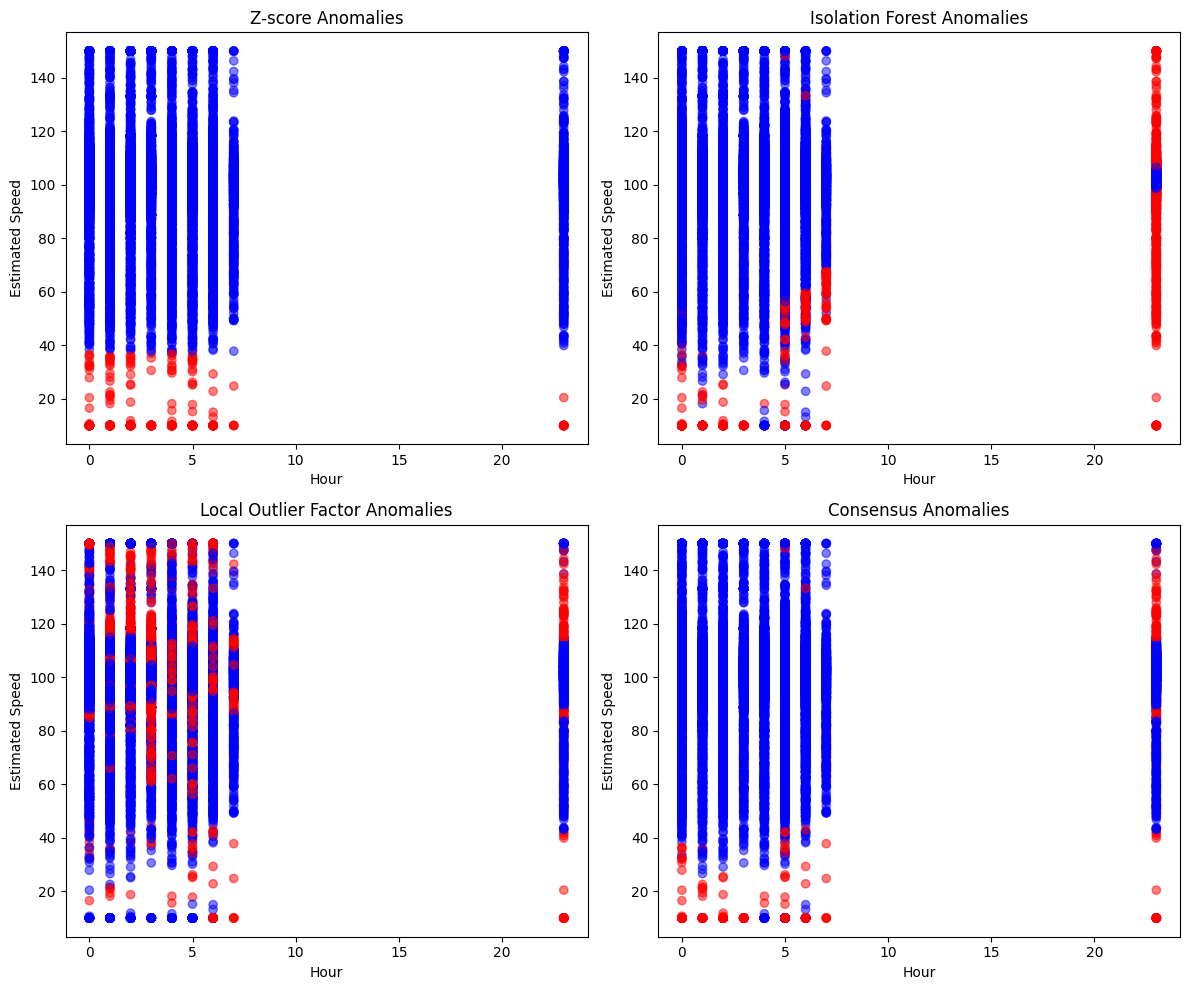


Anomaly Profiles:


,"(estimated_speed, mean)","(estimated_speed, min)","(estimated_speed, max)",mean,min,max
consensus_anomaly,,,,,,
False,105.615850,10.0,150.0,3.810167,0,23
True,45.972532,10.0,150.0,10.749347,0,23



Anomalies by vehicle class:


class_name
truck         3.971708
van           2.586207
motorcycle    2.352941
bus           2.020202
utility       1.427189
car           0.678995
Name: is_anomaly, dtype: object

In [32]:
print("\nAnomaly Detection")
print("------------------")

if "estimated_speed" in df.columns and df["estimated_speed"].notnull().sum() > 100:
    print("Performing anomaly detection on vehicle data")

    # Prepare data for anomaly detection - use available features
    # First check which time-related columns we have
    time_cols = [
        col
        for col in ["hour", "hour_of_day", "day_of_month", "day_of_week"]
        if col in df.columns
    ]

    # Build feature list starting with speed
    anomaly_features = ["estimated_speed"]

    # Add available time columns
    if time_cols:
        anomaly_features.extend(time_cols)

    # Add any other numeric features that might be useful
    for col in ["tracking_count", "total_tracking_duration"]:
        if col in df.columns:
            anomaly_features.append(col)

    # Convert categorical day_of_week to numeric if it exists
    if "day_of_week" in anomaly_features:
        # Create a temporary numeric version
        day_mapping = {
            "Monday": 0,
            "Tuesday": 1,
            "Wednesday": 2,
            "Thursday": 3,
            "Friday": 4,
            "Saturday": 5,
            "Sunday": 6,
        }
        df["day_of_week_num"] = df["day_of_week"].map(day_mapping)
        # Replace in feature list
        anomaly_features.remove("day_of_week")
        anomaly_features.append("day_of_week_num")

    # Convert boolean is_weekend to numeric if it exists
    if "is_weekend" in df.columns:
        df["is_weekend_num"] = df["is_weekend"].astype(int)
        anomaly_features.append("is_weekend_num")

    print(f"Using features for anomaly detection: {anomaly_features}")

    if len(anomaly_features) >= 2:
        # Prepare the anomaly detection dataset
        anomaly_data = df[anomaly_features].copy()
        anomaly_data = anomaly_data.dropna()

        if len(anomaly_data) > 100:  # Only proceed if we have enough data
            # Standardize the data
            from sklearn.preprocessing import StandardScaler

            scaler = StandardScaler()
            scaled_anomaly_data = scaler.fit_transform(anomaly_data)

            # Statistical Methods (Z-score)
            print("\nStatistical Methods (Z-score)")

            # Calculate Z-scores for estimated_speed
            speed_index = anomaly_features.index("estimated_speed")
            z_scores = np.abs(
                (
                    scaled_anomaly_data[:, speed_index]
                    - np.mean(scaled_anomaly_data[:, speed_index])
                )
                / np.std(scaled_anomaly_data[:, speed_index])
            )

            # Define anomalies as points with z-score > 3
            z_score_anomalies = z_scores > 3

            print(
                f"Z-score method identified {sum(z_score_anomalies)} anomalies "
                f"({sum(z_score_anomalies)/len(z_scores)*100:.2f}% of data)"
            )

            # Isolation Forest - a simpler approach
            print("\nIsolation Forest")
            from sklearn.ensemble import IsolationForest

            # Apply Isolation Forest
            iso_forest = IsolationForest(contamination=0.05, random_state=42)
            iso_forest_labels = iso_forest.fit_predict(scaled_anomaly_data)
            iso_forest_anomalies = iso_forest_labels == -1

            print(
                f"Isolation Forest identified {sum(iso_forest_anomalies)} anomalies "
                f"({sum(iso_forest_anomalies)/len(iso_forest_labels)*100:.2f}% of data)"
            )

            # Local Outlier Factor - adding a new method that's effective and simple
            print("\nLocal Outlier Factor")
            from sklearn.neighbors import LocalOutlierFactor

            # Apply LOF
            lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
            lof_labels = lof.fit_predict(scaled_anomaly_data)
            lof_anomalies = lof_labels == -1

            print(
                f"Local Outlier Factor identified {sum(lof_anomalies)} anomalies "
                f"({sum(lof_anomalies)/len(lof_labels)*100:.2f}% of data)"
            )

            # Combine and Visualize Anomalies
            print("\nAnomaly Visualization")

            # Add anomaly flags to the original data
            anomaly_data["z_score_anomaly"] = z_score_anomalies
            anomaly_data["isolation_forest_anomaly"] = iso_forest_anomalies
            anomaly_data["lof_anomaly"] = lof_anomalies

            # Create a consensus anomaly flag (anomaly if detected by at least 2 methods)
            anomaly_data["consensus_anomaly"] = (
                anomaly_data["z_score_anomaly"].astype(int)
                + anomaly_data["isolation_forest_anomaly"].astype(int)
                + anomaly_data["lof_anomaly"].astype(int)
            ) >= 2

            print(
                f"Consensus approach identified {anomaly_data['consensus_anomaly'].sum()} anomalies "
                f"({anomaly_data['consensus_anomaly'].mean()*100:.2f}% of data)"
            )

            # Visualize anomalies - simplified to just 2x2 grid
            import matplotlib.pyplot as plt

            # Choose x-axis for visualization (prefer hour if available)
            x_feature = "hour" if "hour" in anomaly_features else anomaly_features[1]

            plt.figure(figsize=(12, 10))

            # Z-score anomalies
            plt.subplot(2, 2, 1)
            plt.scatter(
                anomaly_data[x_feature],
                anomaly_data["estimated_speed"],
                c=anomaly_data["z_score_anomaly"].map({True: "red", False: "blue"}),
                alpha=0.5,
            )
            plt.title("Z-score Anomalies")
            plt.xlabel(x_feature.replace("_", " ").title())
            plt.ylabel("Estimated Speed")

            # Isolation Forest anomalies
            plt.subplot(2, 2, 2)
            plt.scatter(
                anomaly_data[x_feature],
                anomaly_data["estimated_speed"],
                c=anomaly_data["isolation_forest_anomaly"].map(
                    {True: "red", False: "blue"}
                ),
                alpha=0.5,
            )
            plt.title("Isolation Forest Anomalies")
            plt.xlabel(x_feature.replace("_", " ").title())
            plt.ylabel("Estimated Speed")

            # LOF anomalies
            plt.subplot(2, 2, 3)
            plt.scatter(
                anomaly_data[x_feature],
                anomaly_data["estimated_speed"],
                c=anomaly_data["lof_anomaly"].map({True: "red", False: "blue"}),
                alpha=0.5,
            )
            plt.title("Local Outlier Factor Anomalies")
            plt.xlabel(x_feature.replace("_", " ").title())
            plt.ylabel("Estimated Speed")

            # Consensus anomalies
            plt.subplot(2, 2, 4)
            plt.scatter(
                anomaly_data[x_feature],
                anomaly_data["estimated_speed"],
                c=anomaly_data["consensus_anomaly"].map({True: "red", False: "blue"}),
                alpha=0.5,
            )
            plt.title("Consensus Anomalies")
            plt.xlabel(x_feature.replace("_", " ").title())
            plt.ylabel("Estimated Speed")

            plt.tight_layout()
            plt.show()

            # Profile the anomalies - simplified
            print("\nAnomaly Profiles:")
            anomaly_profile = anomaly_data.groupby("consensus_anomaly").agg(
                {
                    "estimated_speed": ["mean", "min", "max"],
                }
            )
            if x_feature != "estimated_speed":
                x_profile = anomaly_data.groupby("consensus_anomaly")[x_feature].agg(
                    ["mean", "min", "max"]
                )
                anomaly_profile = pd.concat([anomaly_profile, x_profile], axis=1)

            display(anomaly_profile)

            # Add anomaly flags to original dataframe
            df.loc[anomaly_data.index, "is_anomaly"] = anomaly_data["consensus_anomaly"]

            # Count anomalies by category if available
            if "class_name" in df.columns:
                print("\nAnomalies by vehicle class:")
                anomaly_by_class = df.groupby("class_name")["is_anomaly"].mean() * 100
                display(anomaly_by_class.sort_values(ascending=False))
        else:
            print("Not enough data for anomaly detection after removing missing values")
    else:
        print("Not enough features available for anomaly detection")
else:
    print("Not enough data for anomaly detection")


Anomaly Detection
------------------
Performing anomaly detection on vehicle data
Using features: ['estimated_speed', 'hour']

1. Z-Score Method
Threshold: 3
Anomalies found: 391 (1.15%)

2. Isolation Forest
Contamination: 5%
Anomalies found: 1633 (4.80%)

3. Local Outlier Factor
Neighbors: 20, Contamination: 5%
Anomalies found: 1703 (5.00%)

Anomaly Detection Summary:


,Method,Anomalies_Count,Percentage
0,Z-Score,391,1.15
1,Isolation Forest,1633,4.80
2,Local Outlier Factor,1703,5.00



Consensus Anomalies: 544 (1.60%)


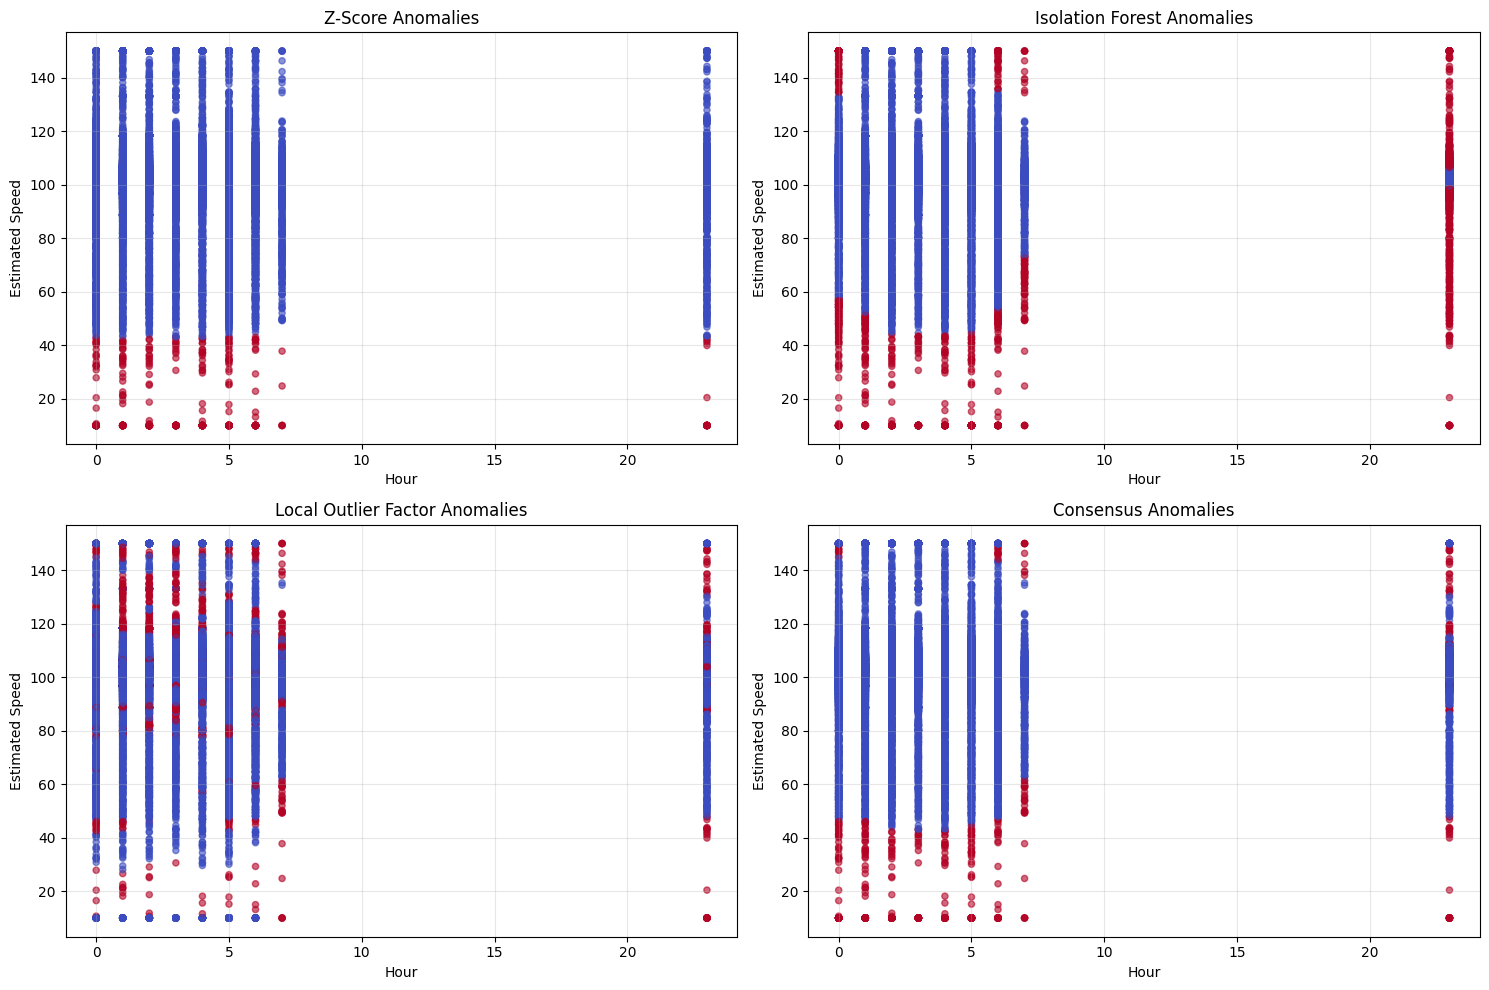


Normal vs Anomaly Statistics:


,Normal_Data,Anomalies
Mean_Speed,105.67,41.74
Std_Speed,18.21,43.10
Min_Speed,43.16,10.00
Max_Speed,150.00,150.00
Count,33503.00,544.00



Sample Anomalies (Top 10 by Speed):


,estimated_speed,hour
25177,150.00,7
25382,150.00,7
25409,150.00,7
25577,150.00,7
20535,149.46,0
31286,149.23,0
21050,149.21,0
15283,148.96,6
19861,148.61,6
30514,148.28,23



Anomalies by Vehicle Class:


,Total_Records,Anomaly_Count,Anomaly_Rate
class_name,,,
truck,6026,215,0.035679
bus,152,5,0.032895
van,2406,77,0.032003
utility,4830,78,0.016149
car,20506,168,0.008193
motorcycle,127,1,0.007874


In [16]:
from scipy import stats


print("\nAnomaly Detection")
print("------------------")

if "estimated_speed" in df.columns and df["estimated_speed"].notnull().sum() > 100:
    print("Performing anomaly detection on vehicle data")

    # Prepare data for anomaly detection - use key features
    anomaly_features = ["estimated_speed"]

    # Add available time features
    if "hour" in df.columns:
        anomaly_features.append("hour")
    if "day_of_month" in df.columns:
        anomaly_features.append("day_of_month")

    # Add other numeric features if available
    for col in ["tracking_count", "total_tracking_duration"]:
        if col in df.columns:
            anomaly_features.append(col)

    print(f"Using features: {anomaly_features}")

    if len(anomaly_features) >= 2:
        # Prepare the anomaly detection dataset
        anomaly_data = df[anomaly_features].copy()
        anomaly_data = anomaly_data.dropna()

        if len(anomaly_data) > 100:
            # Standardize the data
            from sklearn.preprocessing import StandardScaler

            scaler = StandardScaler()
            scaled_data = scaler.fit_transform(anomaly_data)

            # 1. Z-Score Method (Statistical)
            print("\n1. Z-Score Method")
            z_scores = np.abs(stats.zscore(anomaly_data["estimated_speed"]))
            z_threshold = 3
            z_anomalies = z_scores > z_threshold

            print(f"Threshold: {z_threshold}")
            print(
                f"Anomalies found: {z_anomalies.sum()} ({z_anomalies.mean()*100:.2f}%)"
            )

            # 2. Isolation Forest
            print("\n2. Isolation Forest")
            from sklearn.ensemble import IsolationForest

            iso_forest = IsolationForest(contamination=0.05, random_state=42)
            iso_labels = iso_forest.fit_predict(scaled_data)
            iso_anomalies = iso_labels == -1

            print(f"Contamination: 5%")
            print(
                f"Anomalies found: {iso_anomalies.sum()} ({iso_anomalies.mean()*100:.2f}%)"
            )

            # 3. Local Outlier Factor
            print("\n3. Local Outlier Factor")
            from sklearn.neighbors import LocalOutlierFactor

            lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
            lof_labels = lof.fit_predict(scaled_data)
            lof_anomalies = lof_labels == -1

            print(f"Neighbors: 20, Contamination: 5%")
            print(
                f"Anomalies found: {lof_anomalies.sum()} ({lof_anomalies.mean()*100:.2f}%)"
            )

            # Create summary table
            anomaly_summary = pd.DataFrame(
                {
                    "Method": ["Z-Score", "Isolation Forest", "Local Outlier Factor"],
                    "Anomalies_Count": [
                        z_anomalies.sum(),
                        iso_anomalies.sum(),
                        lof_anomalies.sum(),
                    ],
                    "Percentage": [
                        z_anomalies.mean() * 100,
                        iso_anomalies.mean() * 100,
                        lof_anomalies.mean() * 100,
                    ],
                }
            )

            print("\nAnomaly Detection Summary:")
            display(anomaly_summary.round(2))

            # Add anomaly flags to data
            anomaly_data["z_score_anomaly"] = z_anomalies
            anomaly_data["isolation_anomaly"] = iso_anomalies
            anomaly_data["lof_anomaly"] = lof_anomalies

            # Consensus: anomaly if detected by at least 2 methods
            anomaly_data["consensus_anomaly"] = (
                anomaly_data["z_score_anomaly"].astype(int)
                + anomaly_data["isolation_anomaly"].astype(int)
                + anomaly_data["lof_anomaly"].astype(int)
            ) >= 2

            consensus_count = anomaly_data["consensus_anomaly"].sum()
            print(
                f"\nConsensus Anomalies: {consensus_count} ({anomaly_data['consensus_anomaly'].mean()*100:.2f}%)"
            )

            # Visualization
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))

            # Choose x-axis (prefer hour if available)
            x_col = "hour" if "hour" in anomaly_features else anomaly_features[1]

            # Z-Score anomalies
            axes[0, 0].scatter(
                anomaly_data[x_col],
                anomaly_data["estimated_speed"],
                c=anomaly_data["z_score_anomaly"],
                cmap="coolwarm",
                alpha=0.6,
                s=20,
            )
            axes[0, 0].set_title("Z-Score Anomalies")
            axes[0, 0].set_xlabel(x_col.replace("_", " ").title())
            axes[0, 0].set_ylabel("Estimated Speed")
            axes[0, 0].grid(True, alpha=0.3)

            # Isolation Forest
            axes[0, 1].scatter(
                anomaly_data[x_col],
                anomaly_data["estimated_speed"],
                c=anomaly_data["isolation_anomaly"],
                cmap="coolwarm",
                alpha=0.6,
                s=20,
            )
            axes[0, 1].set_title("Isolation Forest Anomalies")
            axes[0, 1].set_xlabel(x_col.replace("_", " ").title())
            axes[0, 1].set_ylabel("Estimated Speed")
            axes[0, 1].grid(True, alpha=0.3)

            # LOF
            axes[1, 0].scatter(
                anomaly_data[x_col],
                anomaly_data["estimated_speed"],
                c=anomaly_data["lof_anomaly"],
                cmap="coolwarm",
                alpha=0.6,
                s=20,
            )
            axes[1, 0].set_title("Local Outlier Factor Anomalies")
            axes[1, 0].set_xlabel(x_col.replace("_", " ").title())
            axes[1, 0].set_ylabel("Estimated Speed")
            axes[1, 0].grid(True, alpha=0.3)

            # Consensus
            axes[1, 1].scatter(
                anomaly_data[x_col],
                anomaly_data["estimated_speed"],
                c=anomaly_data["consensus_anomaly"],
                cmap="coolwarm",
                alpha=0.6,
                s=20,
            )
            axes[1, 1].set_title("Consensus Anomalies")
            axes[1, 1].set_xlabel(x_col.replace("_", " ").title())
            axes[1, 1].set_ylabel("Estimated Speed")
            axes[1, 1].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            # Anomaly statistics table
            normal_data = anomaly_data[~anomaly_data["consensus_anomaly"]]
            anomaly_subset = anomaly_data[anomaly_data["consensus_anomaly"]]

            if len(anomaly_subset) > 0:
                stats_comparison = pd.DataFrame(
                    {
                        "Normal_Data": [
                            normal_data["estimated_speed"].mean(),
                            normal_data["estimated_speed"].std(),
                            normal_data["estimated_speed"].min(),
                            normal_data["estimated_speed"].max(),
                            len(normal_data),
                        ],
                        "Anomalies": [
                            anomaly_subset["estimated_speed"].mean(),
                            anomaly_subset["estimated_speed"].std(),
                            anomaly_subset["estimated_speed"].min(),
                            anomaly_subset["estimated_speed"].max(),
                            len(anomaly_subset),
                        ],
                    },
                    index=[
                        "Mean_Speed",
                        "Std_Speed",
                        "Min_Speed",
                        "Max_Speed",
                        "Count",
                    ],
                )

                print("\nNormal vs Anomaly Statistics:")
                display(stats_comparison.round(2))

                # Sample of detected anomalies
                print("\nSample Anomalies (Top 10 by Speed):")
                anomaly_sample = anomaly_subset.nlargest(10, "estimated_speed")[
                    ["estimated_speed", x_col]
                ]
                display(anomaly_sample.round(2))

            # Add anomaly flag to main dataframe
            df.loc[anomaly_data.index, "is_anomaly"] = anomaly_data["consensus_anomaly"]

            # Anomalies by category if available
            if "class_name" in df.columns:
                anomaly_by_class = (
                    df.groupby("class_name")["is_anomaly"]
                    .agg(["count", "sum", "mean"])
                    .round(3)
                )
                anomaly_by_class.columns = [
                    "Total_Records",
                    "Anomaly_Count",
                    "Anomaly_Rate",
                ]
                anomaly_by_class = anomaly_by_class.sort_values(
                    "Anomaly_Rate", ascending=False
                )

                print("\nAnomalies by Vehicle Class:")
                display(anomaly_by_class)

        else:
            print("Not enough data after removing missing values")
    else:
        print("Not enough features available")
else:
    print("Insufficient speed data for anomaly detection")

### Findings & Insights


Findings & Insights
----------------------------

Traffic Patterns


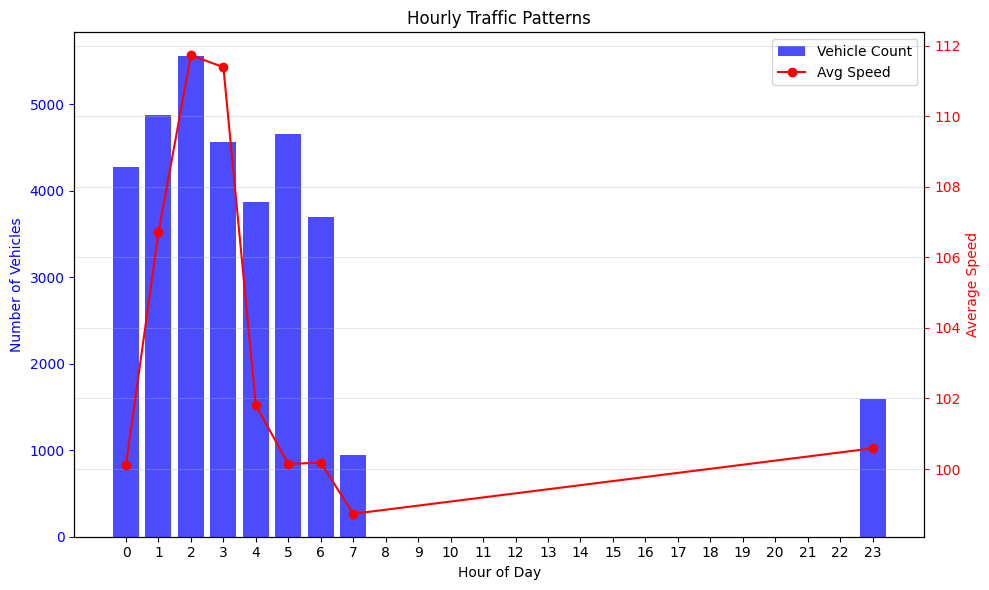

Peak traffic hour: 2:00 with 5556 vehicles
Lowest traffic hour: 7:00 with 949 vehicles
Fastest average speed at 2:00 (111.73)
Slowest average speed at 7:00 (98.73)


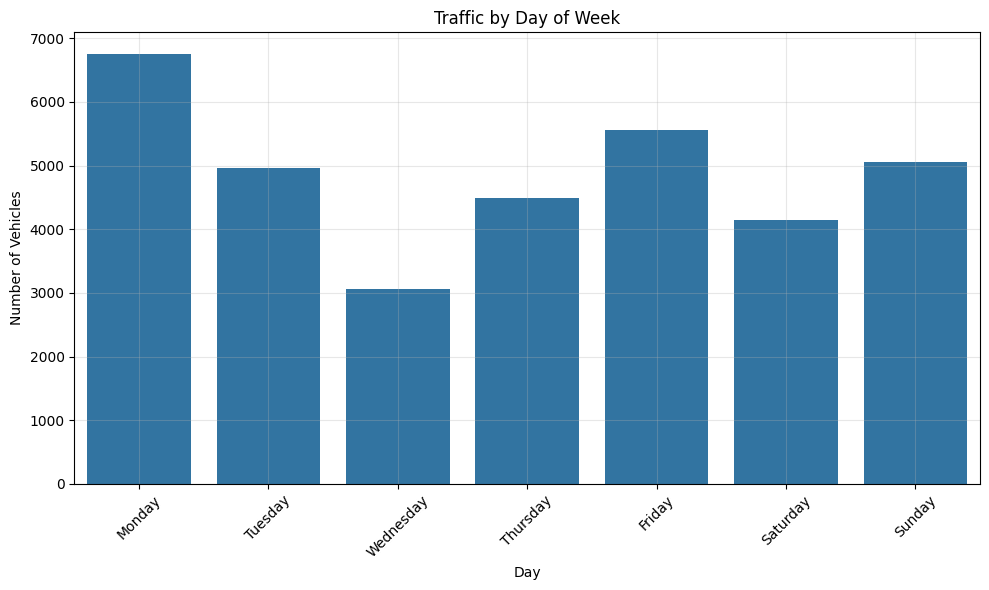

Busiest day: Monday with 6755 vehicles
Quietest day: Wednesday with 3069 vehicles


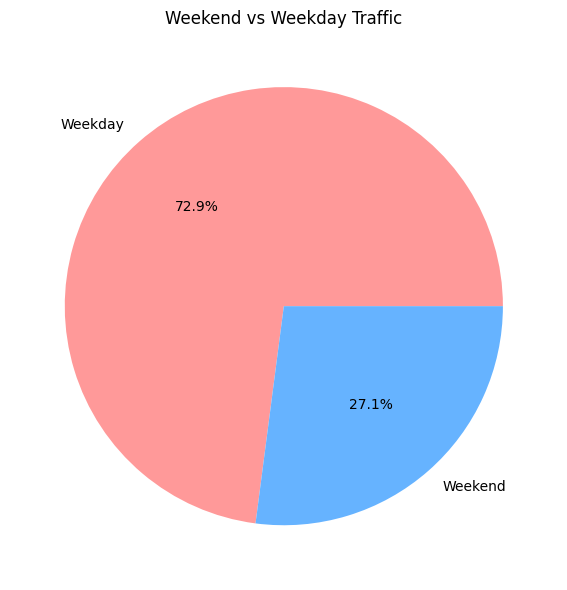

Average weekday traffic: 4966.6 vehicles per day
Average weekend traffic: 4607.0 vehicles per day


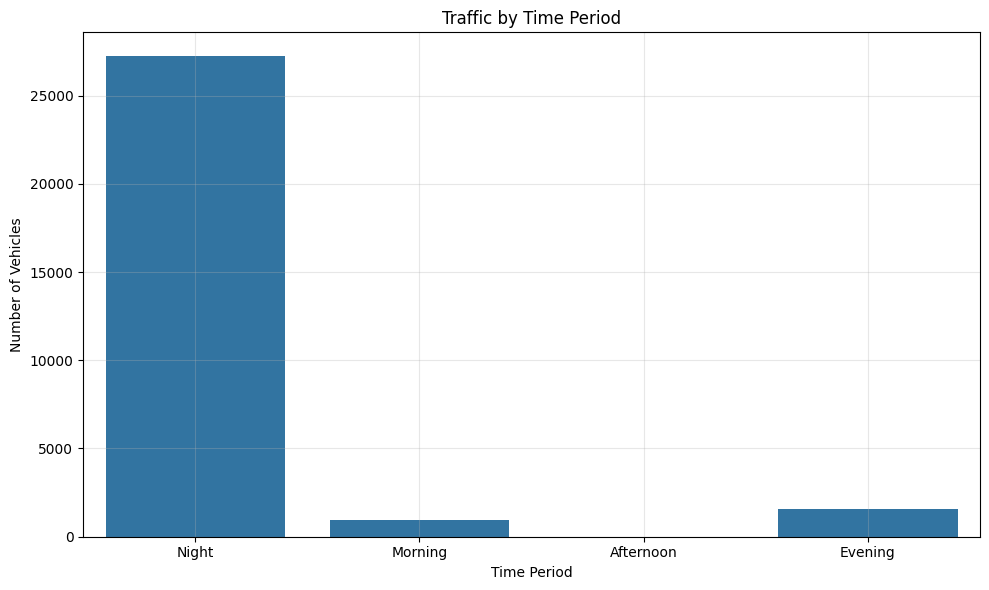

Busiest time period: Night with 27225 vehicles


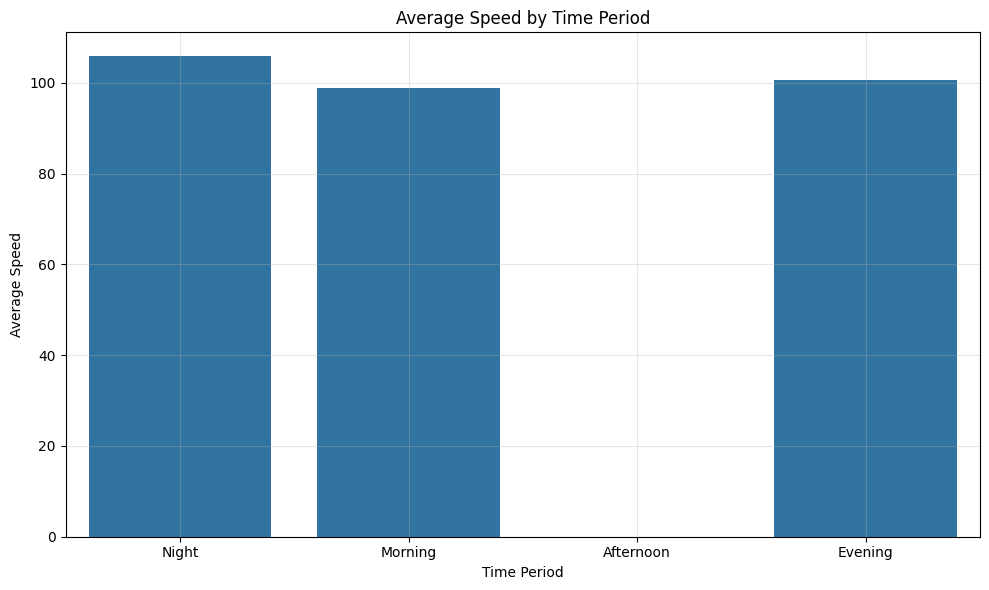

Fastest time period: Night (105.81)
Slowest time period: Morning (98.73)


In [17]:
print("\nFindings & Insights")
print("----------------------------")

# Traffic Patterns
print("\nTraffic Patterns")

# Check if we have hour column (from simplified feature engineering)
if "hour" in df.columns and "estimated_speed" in df.columns:
    # Hourly traffic patterns
    hourly_traffic = df.groupby("hour").size()
    hourly_speed = df.groupby("hour")["estimated_speed"].mean()

    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()

    # Plot vehicle count bars
    ax1.bar(
        hourly_traffic.index,
        hourly_traffic.values,
        alpha=0.7,
        color="blue",
        label="Vehicle Count",
    )
    ax1.set_xlabel("Hour of Day")
    ax1.set_ylabel("Number of Vehicles", color="blue")
    ax1.tick_params(axis="y", colors="blue")

    # Plot average speed line
    ax2.plot(
        hourly_speed.index,
        hourly_speed.values,
        color="red",
        marker="o",
        label="Avg Speed",
    )
    ax2.set_ylabel("Average Speed", color="red")
    ax2.tick_params(axis="y", colors="red")

    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

    plt.title("Hourly Traffic Patterns")
    plt.xticks(range(0, 24))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Find peak hours
    peak_hour = hourly_traffic.idxmax()
    lowest_hour = hourly_traffic.idxmin()
    fastest_hour = hourly_speed.idxmax()
    slowest_hour = hourly_speed.idxmin()

    print(
        f"Peak traffic hour: {peak_hour}:00 with {hourly_traffic[peak_hour]} vehicles"
    )
    print(
        f"Lowest traffic hour: {lowest_hour}:00 with {hourly_traffic[lowest_hour]} vehicles"
    )
    print(
        f"Fastest average speed at {fastest_hour}:00 ({hourly_speed[fastest_hour]:.2f})"
    )
    print(
        f"Slowest average speed at {slowest_hour}:00 ({hourly_speed[slowest_hour]:.2f})"
    )

# Day of week patterns
if "day_of_week" in df.columns:
    # Order days properly
    day_order = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]

    # Get counts by day
    day_counts = df["day_of_week"].value_counts().reindex(day_order)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=day_counts.index, y=day_counts.values)
    plt.title("Traffic by Day of Week")
    plt.xlabel("Day")
    plt.ylabel("Number of Vehicles")
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Find busiest and quietest days
    busiest_day = day_counts.idxmax()
    quietest_day = day_counts.idxmin()

    print(f"Busiest day: {busiest_day} with {day_counts[busiest_day]} vehicles")
    print(f"Quietest day: {quietest_day} with {day_counts[quietest_day]} vehicles")

    # Weekend vs Weekday comparison
    if "is_weekend" in df.columns:
        weekend_counts = df.groupby("is_weekend").size()
        weekend_label = {True: "Weekend", False: "Weekday"}

        plt.figure(figsize=(8, 6))
        plt.pie(
            weekend_counts,
            labels=[weekend_label[x] for x in weekend_counts.index],
            autopct="%1.1f%%",
            colors=["#ff9999", "#66b3ff"],
        )
        plt.title("Weekend vs Weekday Traffic")
        plt.tight_layout()
        plt.show()

        # Calculate average daily traffic
        weekday_avg = weekend_counts[False] / 5 if False in weekend_counts.index else 0
        weekend_avg = weekend_counts[True] / 2 if True in weekend_counts.index else 0

        print(f"Average weekday traffic: {weekday_avg:.1f} vehicles per day")
        print(f"Average weekend traffic: {weekend_avg:.1f} vehicles per day")

# Time period analysis
if "time_period" in df.columns:
    period_counts = df["time_period"].value_counts()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=period_counts.index, y=period_counts.values)
    plt.title("Traffic by Time Period")
    plt.xlabel("Time Period")
    plt.ylabel("Number of Vehicles")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Find busiest period
    busiest_period = period_counts.idxmax()
    print(
        f"Busiest time period: {busiest_period} with {period_counts[busiest_period]} vehicles"
    )

    # If we have speed data, analyze by time period
    if "estimated_speed" in df.columns:
        period_speed = df.groupby("time_period")["estimated_speed"].mean()

        plt.figure(figsize=(10, 6))
        sns.barplot(x=period_speed.index, y=period_speed.values)
        plt.title("Average Speed by Time Period")
        plt.xlabel("Time Period")
        plt.ylabel("Average Speed")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Find fastest/slowest periods
        fastest_period = period_speed.idxmax()
        slowest_period = period_speed.idxmin()

        print(
            f"Fastest time period: {fastest_period} ({period_speed[fastest_period]:.2f})"
        )
        print(
            f"Slowest time period: {slowest_period} ({period_speed[slowest_period]:.2f})"
        )